# **Libraries and Data Load**

Instalamos Nevergrad para realizar más adelante la optimización de hiperparámetros.

In [ ]:
!pip install nevergrad

     |████████████████████████████████| 411 kB 5.0 MB/s 
     |████████████████████████████████| 269 kB 47.5 MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=ccb06cb4062b8f4b5103f6e514f1b34923afcfca0176762dc7c1714616145755
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [ ]:
import pandas as pd
import numpy as np
import os
import sklearn.compose
from sklearn.model_selection import train_test_split
import nevergrad as ng
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
import tensorflow as tf
import tensorflow.keras as K
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from keras import backend as Ke

Se cargan los datos de entrenamiento y los necesarios para hacer la predicción desde un repositorio online. Los datos de entrenamiento se mezclan de forma aleatoria.

In [ ]:
data_test = pd.read_csv("https://raw.githubusercontent.com/bipbopbup/ML/main/test2.csv", sep=",")

data_train1 = pd.read_csv("https://raw.githubusercontent.com/bipbopbup/ML/main/train2.1.csv", sep=",")
data_train2 = pd.read_csv("https://raw.githubusercontent.com/bipbopbup/ML/main/train2.2.csv", sep=",")

data_train = data_train1.append(data_train2, ignore_index=True)
data_train = data_train.sample(frac=1, random_state=96).reset_index(drop=True)

y = data_train['round_winner']
data_train.drop(columns='round_winner.1', inplace=True)

data_train

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,54.94,0.0,3.0,de_overpass,False,500.0,500.0,500.0,442.0,600.0,25200.0,1.0,5.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,T
1,74.89,1.0,2.0,de_nuke,False,356.0,204.0,398.0,0.0,4400.0,8500.0,3.0,0.0,2.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT
2,94.91,8.0,8.0,de_overpass,False,500.0,451.0,500.0,0.0,450.0,11200.0,4.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,174.95,12.0,13.0,de_nuke,False,500.0,500.0,0.0,100.0,29050.0,38500.0,0.0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
4,74.96,4.0,10.0,de_nuke,False,100.0,284.0,100.0,398.0,650.0,15200.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,174.95,4.0,10.0,de_inferno,False,500.0,500.0,80.0,277.0,21100.0,45650.0,1.0,3.0,1.0,5.0,5.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
73442,172.10,3.0,2.0,de_dust2,False,500.0,500.0,400.0,472.0,4050.0,5100.0,2.0,5.0,1.0,5.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,

**transfrom_Y** se encarga de transformar la columna de salida en dos columnas objetivo (una de victoria contraterrorista y otra de victoria terrorista).

**inverse_transform_Y** se encarga de hacer el proceso contrario del método anterior.

In [ ]:
onehot = sklearn.preprocessing.OneHotEncoder()
def transform_Y (y):
  result = []
  for el in y:
    result.append([el])
  result = onehot.fit_transform(result).toarray()
  return pd.DataFrame(result, columns=y.unique())

def inverse_transform_Y (y, index=None):
  aux = onehot.inverse_transform(y)
  result = []
  for el in aux:
    result.append(el[0])
  return pd.Series(result, index=index)

**f1_score_m** implementa la métrica de calidad f1 y hace uso de los métodos **recall_m** y **precision_m** para calcularla.

In [ ]:
def recall_m(y_true, y_pred):
  true_positives = Ke.sum(Ke.round(Ke.clip(y_true * y_pred, 0, 1)))
  possible_positives = Ke.sum(Ke.round(Ke.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + Ke.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = Ke.sum(Ke.round(Ke.clip(y_true * y_pred, 0, 1)))
  predicted_positives = Ke.sum(Ke.round(Ke.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + Ke.epsilon())
  return precision

def f1_score_m (y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+Ke.epsilon()))

# **Initial Study**

## *Describe*


Se describen los datos correspondientes a cada columna.


In [ ]:
data_train.describe(include="all")

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
count,73446.000000,73446.000000,73446.000000,73446,73446,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.00000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.0,73446.000000,73446.000000,...,73446.000000,73446.0,73446.000000,73446.0,73446.000000,73446.000000,73446.0,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446.000000,73446
unique,NaN,NaN,NaN,8,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,de_inferno,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T
freq,NaN,NaN,NaN,14257,65203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37444
mean,97.879891,6.700324,6.776720,NaN,NaN,411.646883,402.341339,314.032337,298.506849,9726.591646,11204.361708,2.044822,2.771805,1.604757,4.269150,4.262696,0.274093,1.244670,0.135855,0.007570,0.57095,0.321079,0.0,0.000123,0.150723,0.106895,0.004044,0.001675,0.110503,0.004847,0.0,0.000803,0.010756,0.109169,0.006685,3.305177,0.000014,0.0,0.063325,0.002723,...,0.000136,0.0,0.000054,0.0,0.000136,0.000749,0.0,0.236473,0.822591,0.060085,0.020968,0.046647,0.035822,0.007557,0.000313,0.442025,0.381028,0.061433,0.009585,3.177328,0.121600,0.234989,0.292215,0.174536,0.005147,0.008033,0.028565,0.895529,0.437001,1.847153,1.860469,1.537116,1.622580,0.997481,0.020015,0.047600,1.352817,0.027966,0.025257,NaN
std,54.483397,4.798172,4.82546

## *Relación columna-objetivo*

Se estudian las posibles relaciones entre cada columna y la variable objetivo.

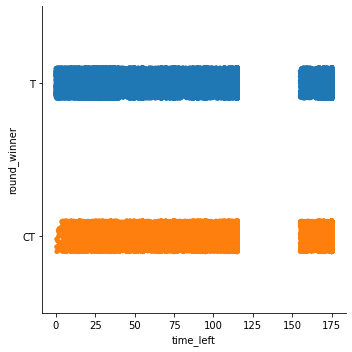

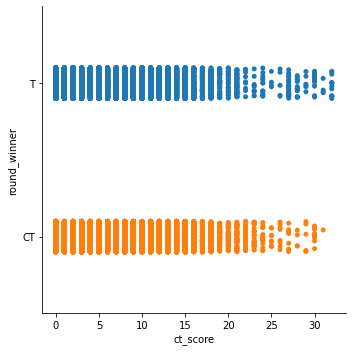

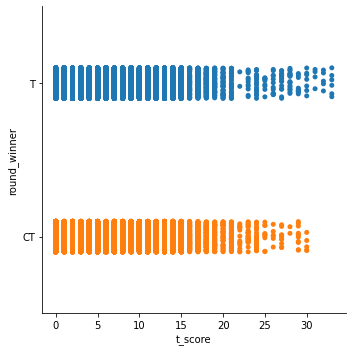

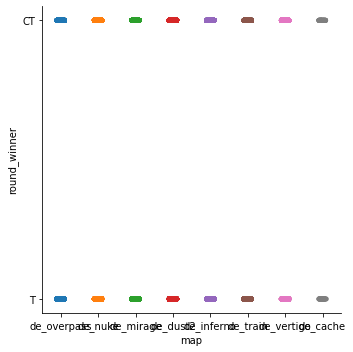

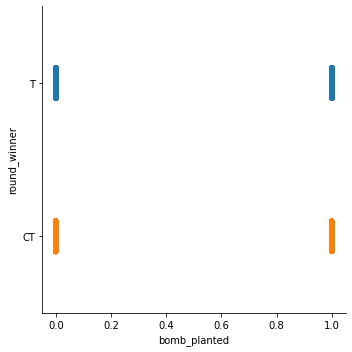

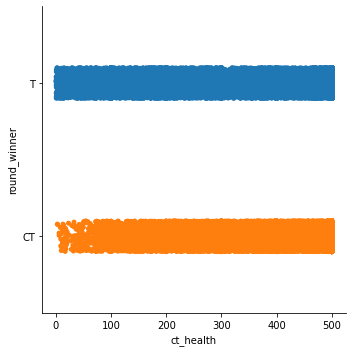

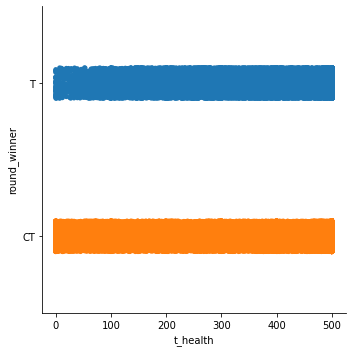

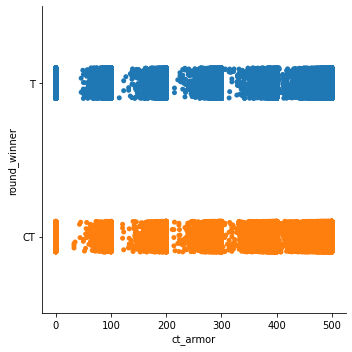

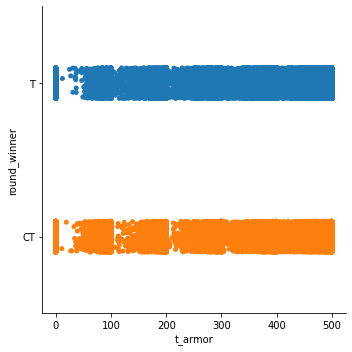

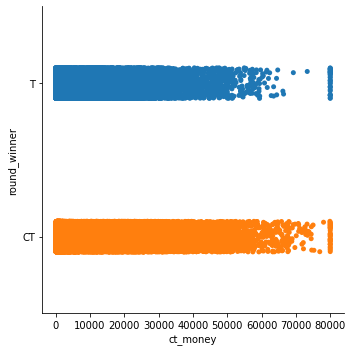

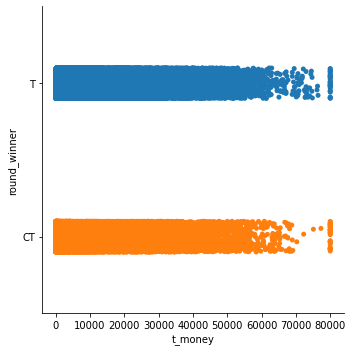

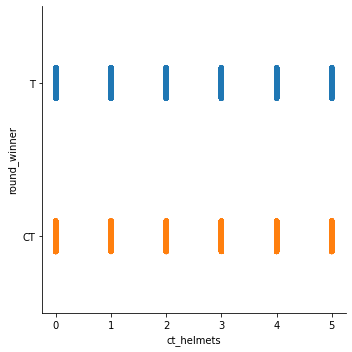

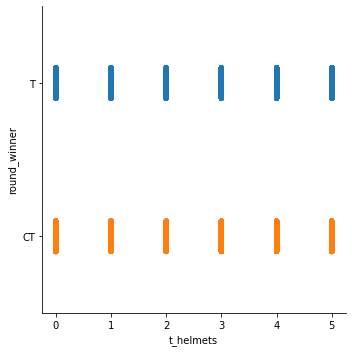

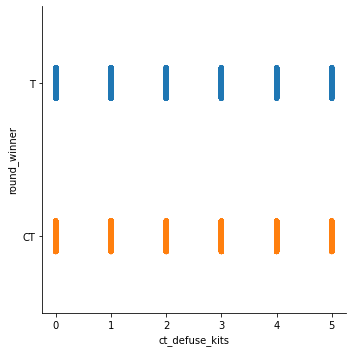

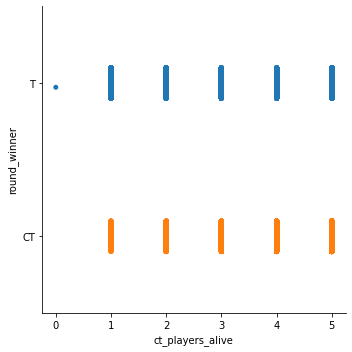

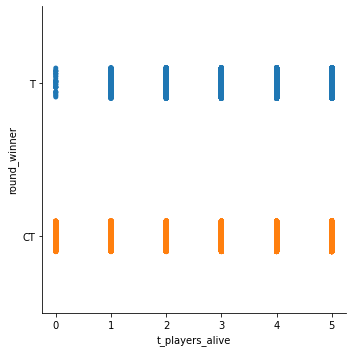

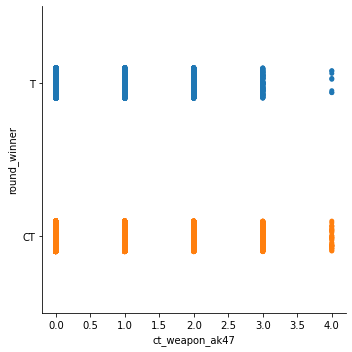

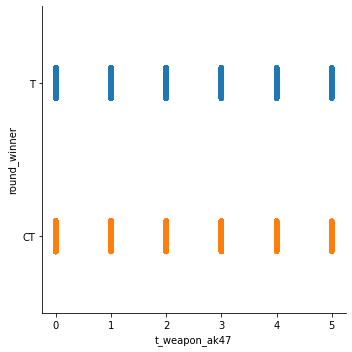

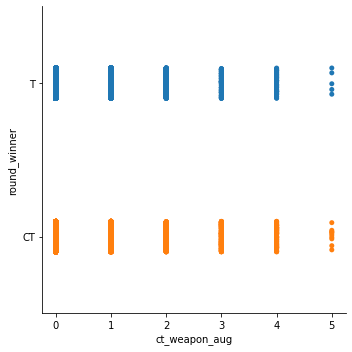

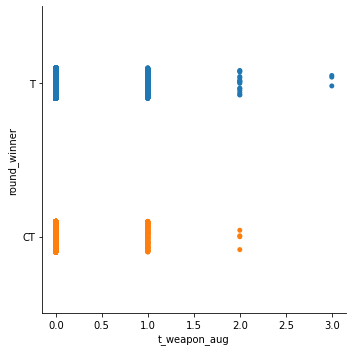

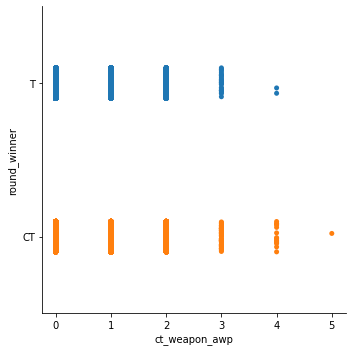

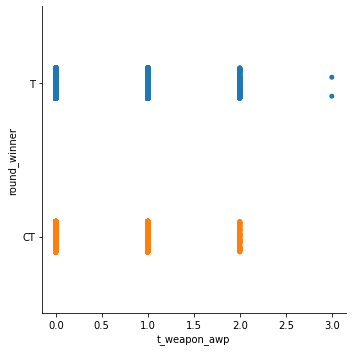

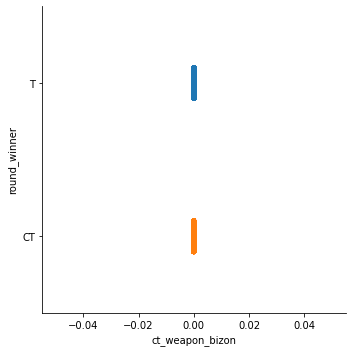

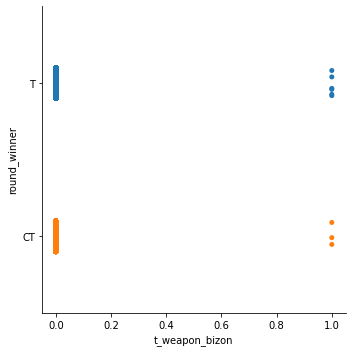

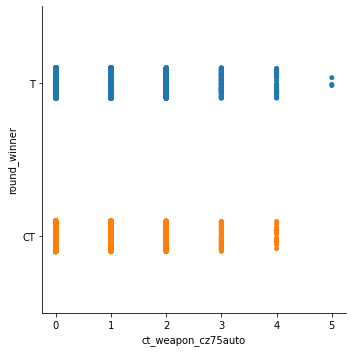

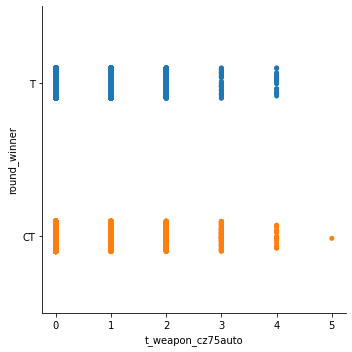

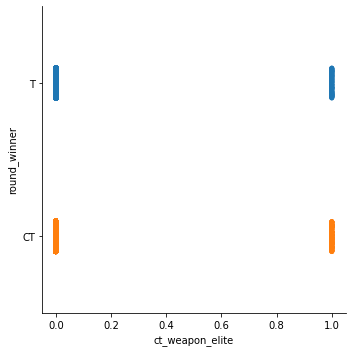

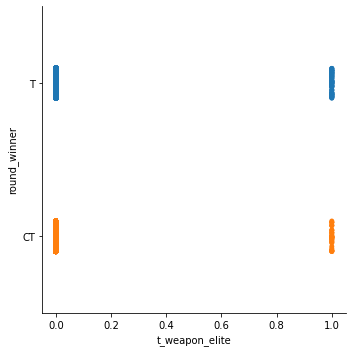

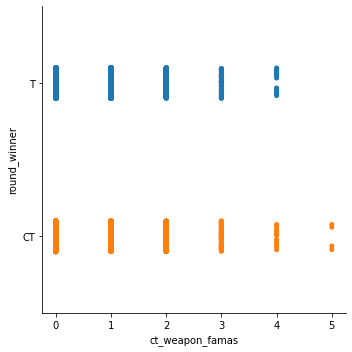

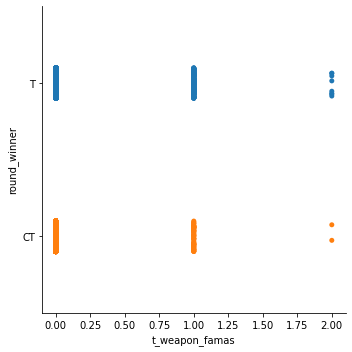

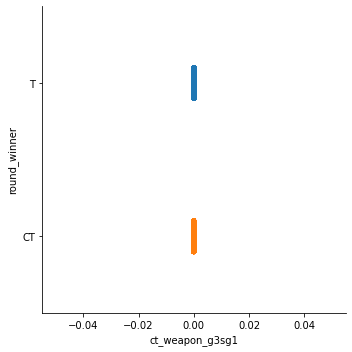

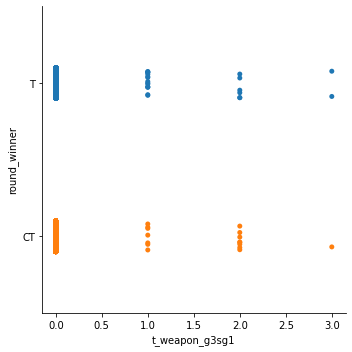

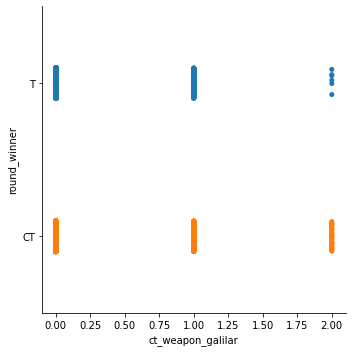

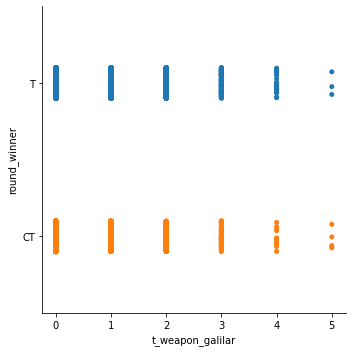

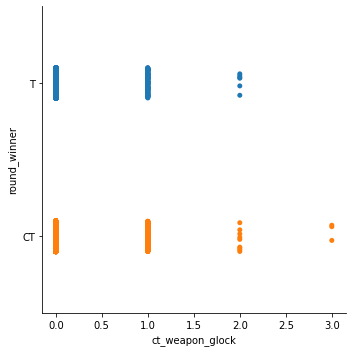

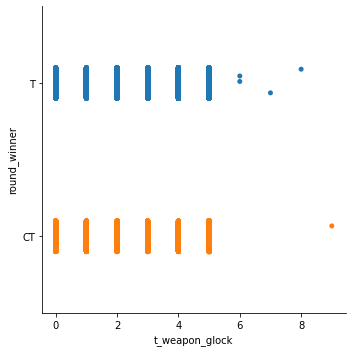

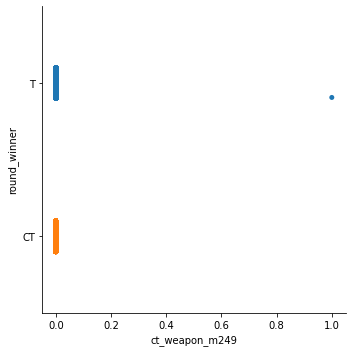

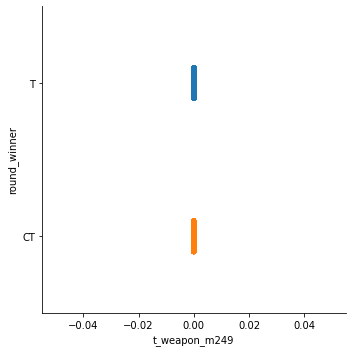

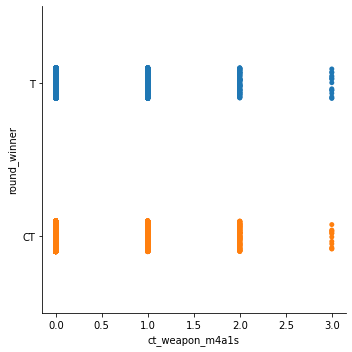

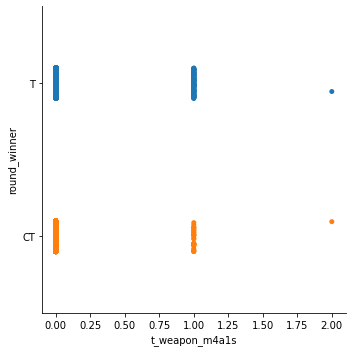

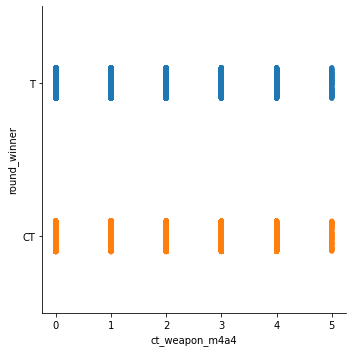

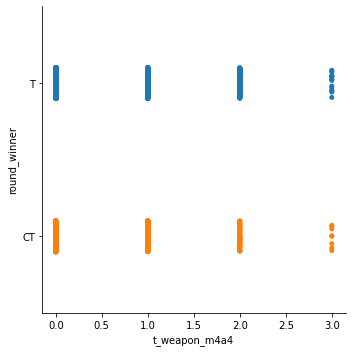

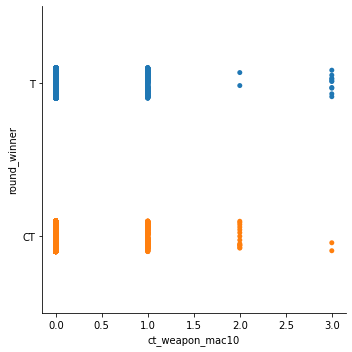

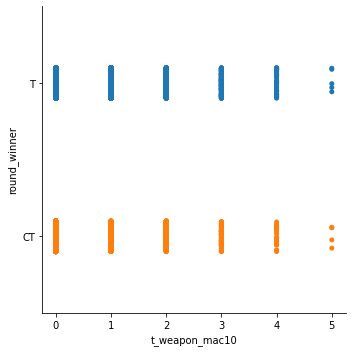

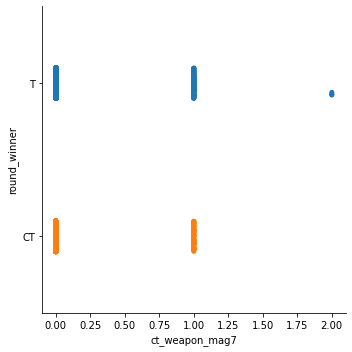

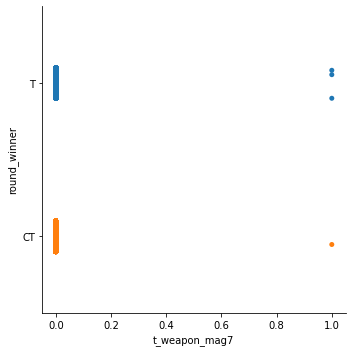

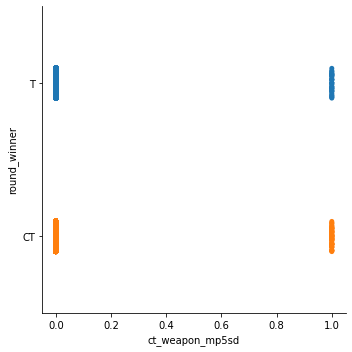

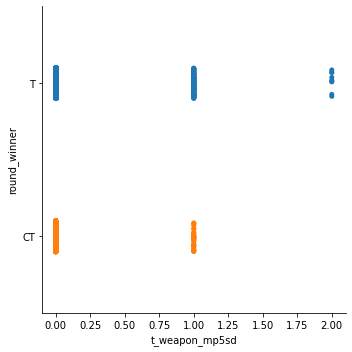

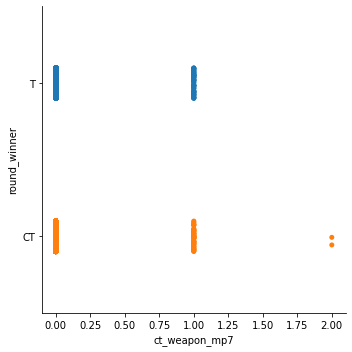

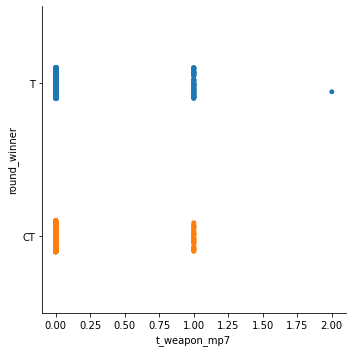

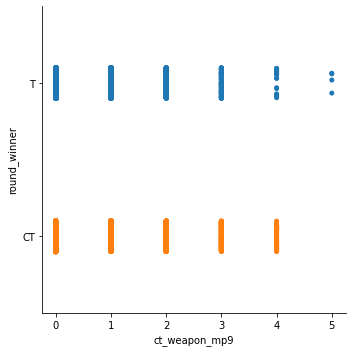

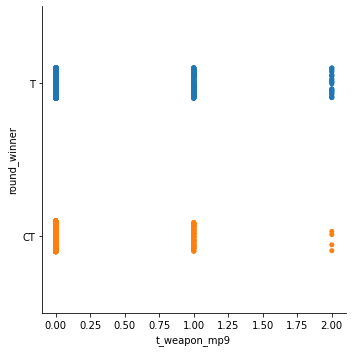

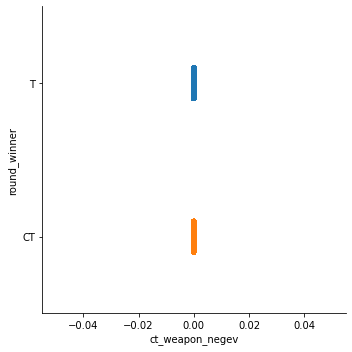

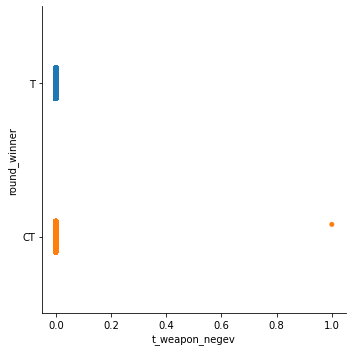

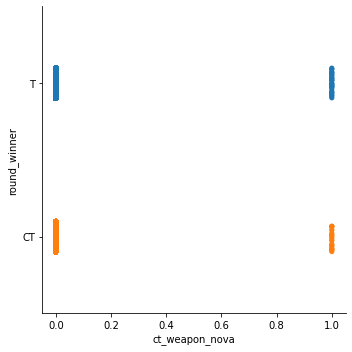

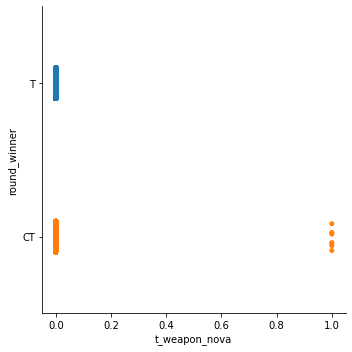

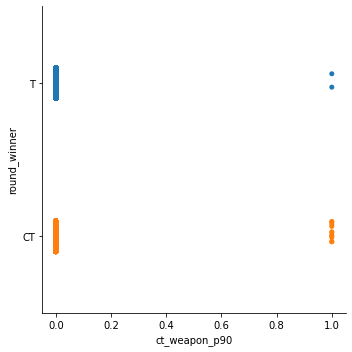

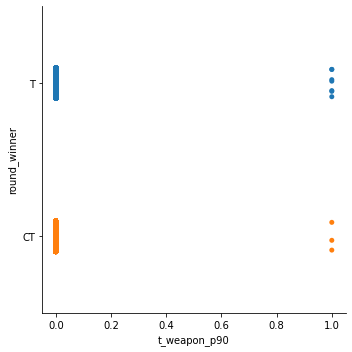

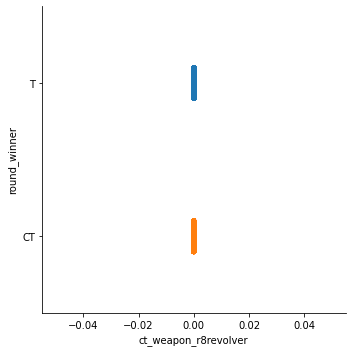

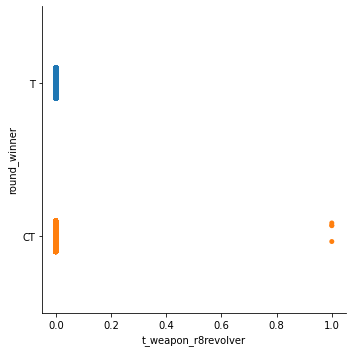

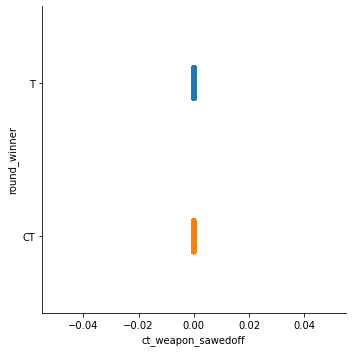

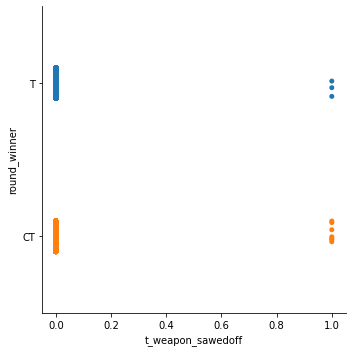

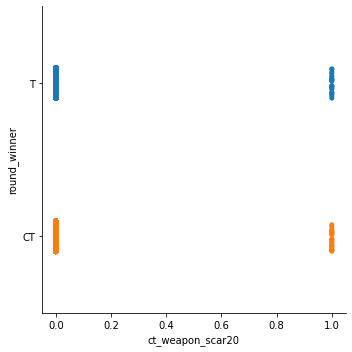

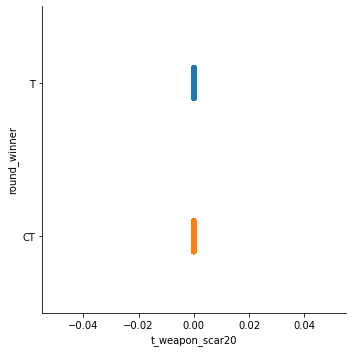

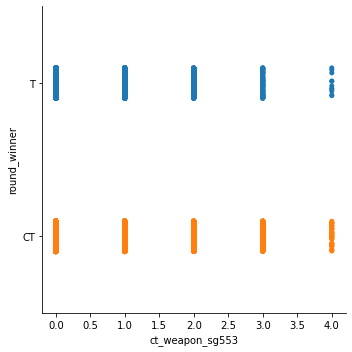

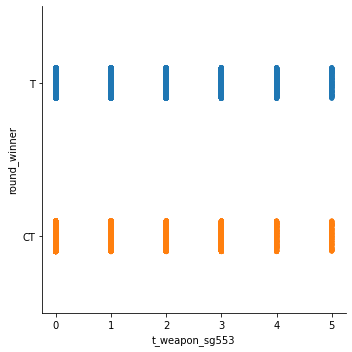

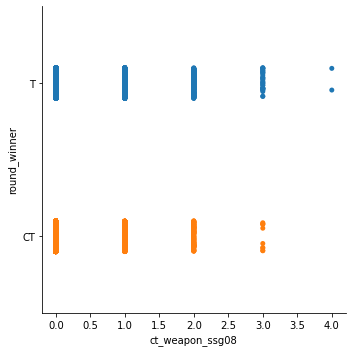

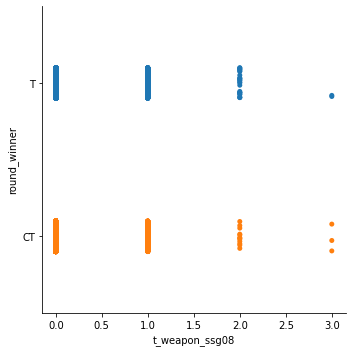

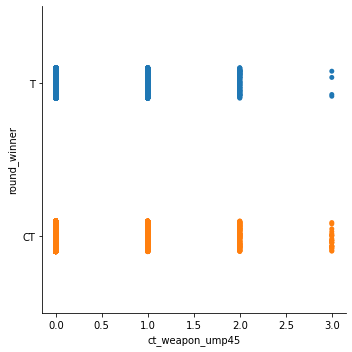

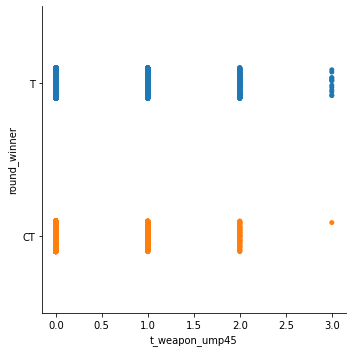

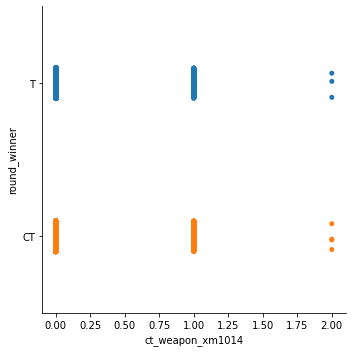

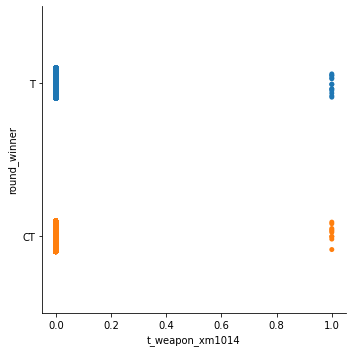

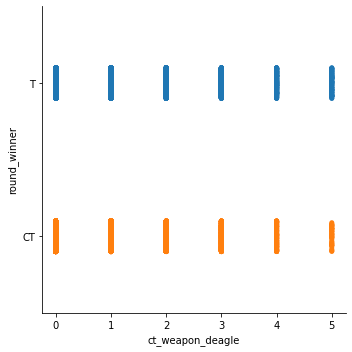

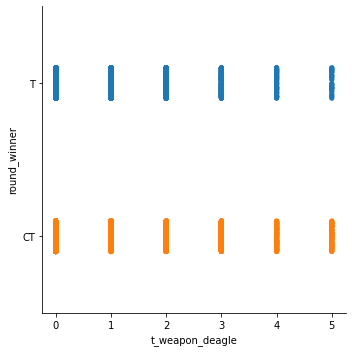

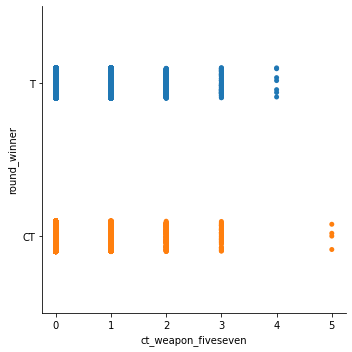

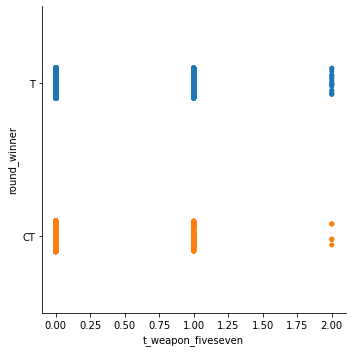

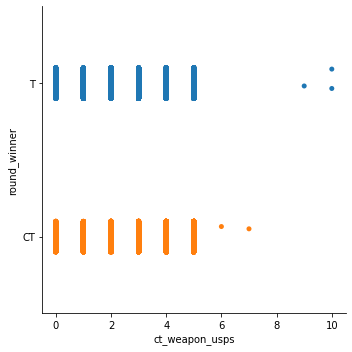

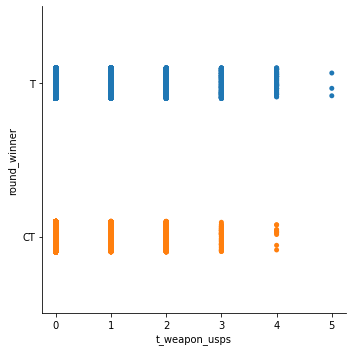

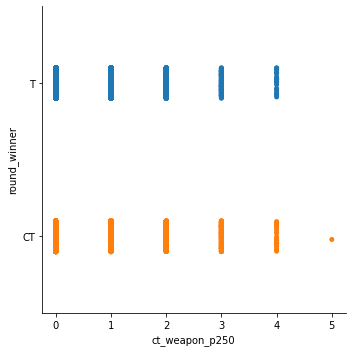

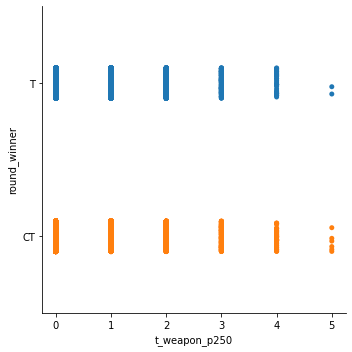

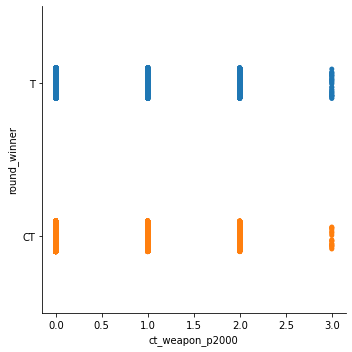

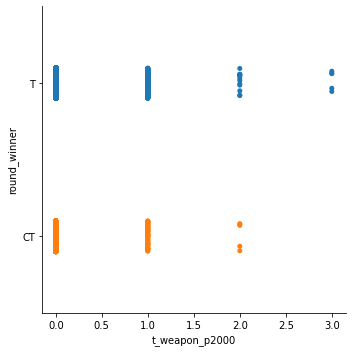

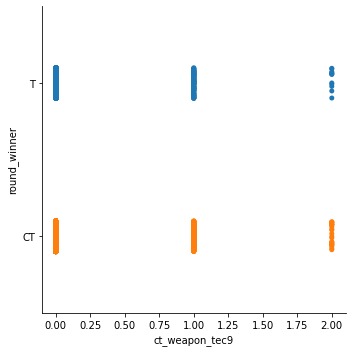

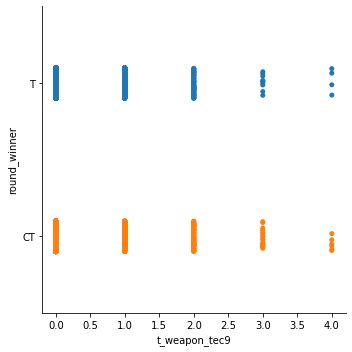

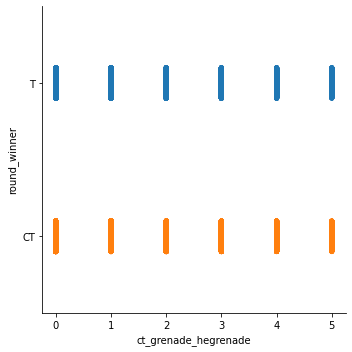

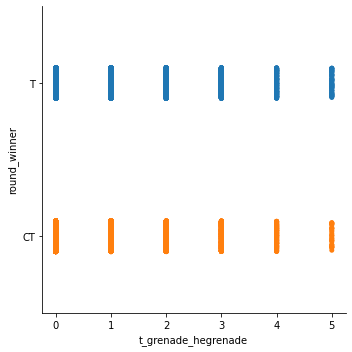

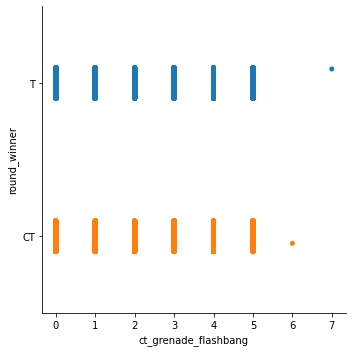

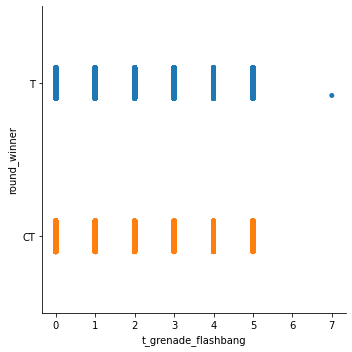

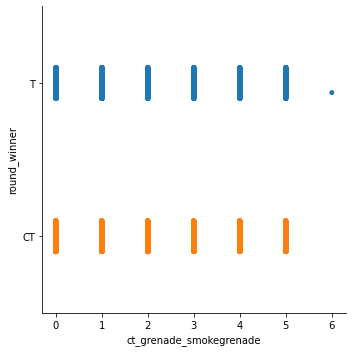

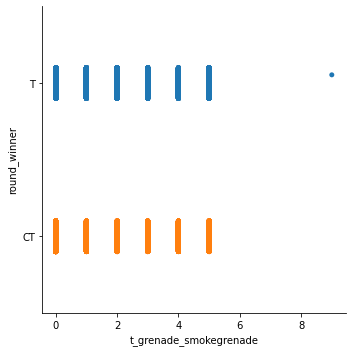

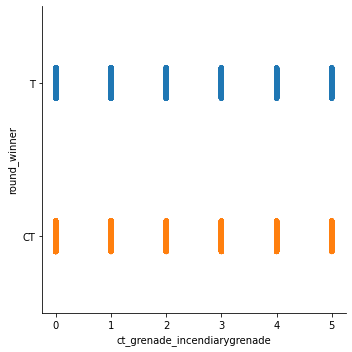

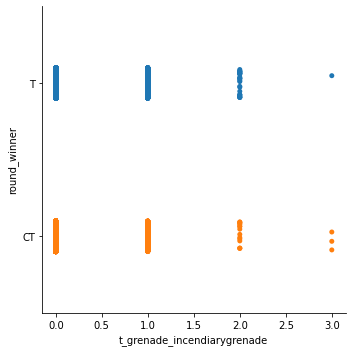

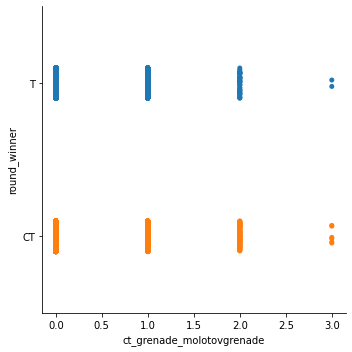

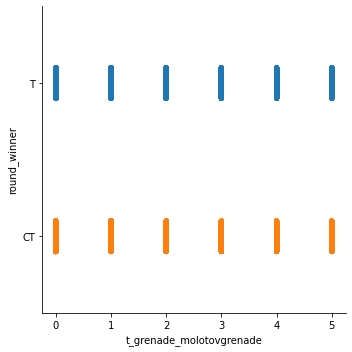

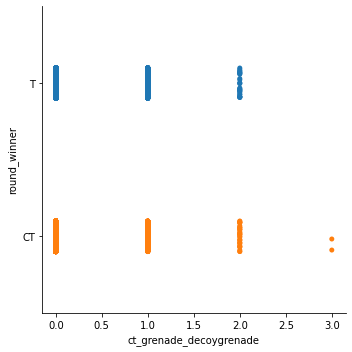

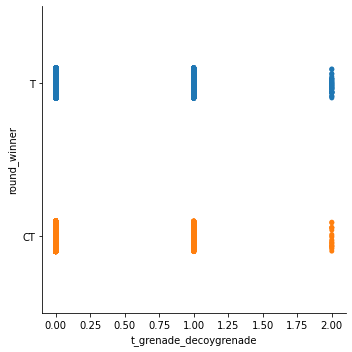

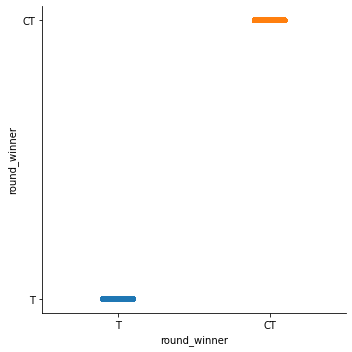

In [ ]:
warnings.filterwarnings("ignore")
for column in data_train:
  aux = pd.DataFrame({column: data_train[column], 'round_winner': data_train['round_winner']})
  sns.catplot(x=column, y='round_winner', data=aux)
warnings.filterwarnings("default")

## *Correlación columna-objetivo*

Se dibuja la matriz de correlación entre cada columna y la variable objetivo.

In [ ]:
round_winner = transform_Y(data_train['round_winner'])
round_winner.drop(columns='CT', inplace=True)

result = []
for column in data_train.columns:
  aux = pd.DataFrame({column: data_train[column], 'round_winner': round_winner['T']})
  matrizCorrelacion = aux.corr(method='pearson')
  result.append(matrizCorrelacion['round_winner'][0])

aux = pd.DataFrame({'round_winner': result}, index = data_train.columns)

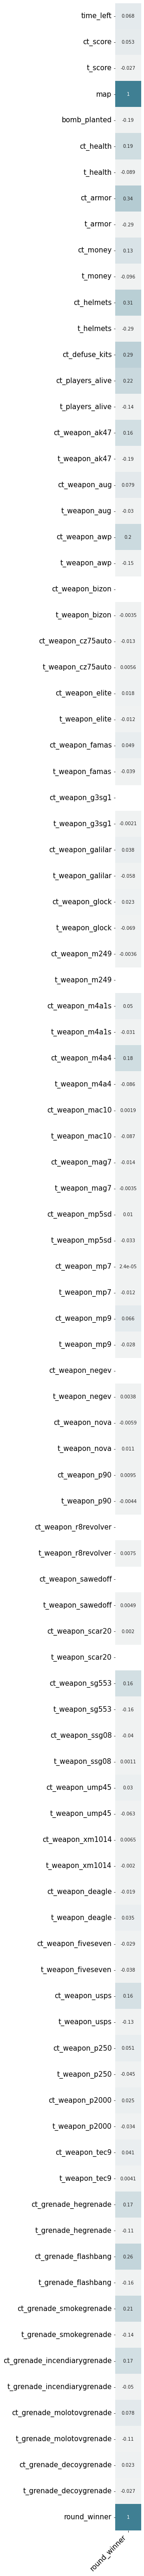

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (100, 100))

sns.heatmap(
    aux,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 10},
    vmin      = 0,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 15)

# **Preprocessing**


## *Columna score y armor elevada al cubo* (no utilizado en el clasificador final)

Elevamos ambas columnas score y luego armor al cubo. Este preprocesamiento no mejoraba nuestro resultado final.

In [ ]:
def scoreCTAlCubo(row):
  return row.ct_score**3

def scoreTAlCubo(row):
  return row.t_score**3

data_train['ct_score'] = data_train.apply(scoreCTAlCubo, axis=1)
data_test['ct_score'] = data_test.apply(scoreCTAlCubo, axis=1)
data_train['t_score'] = data_train.apply(scoreTAlCubo, axis=1)
data_test['t_score'] = data_test.apply(scoreTAlCubo, axis=1)

data_train

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,54.94,0.0,27.0,de_overpass,False,500.0,500.0,500.0,442.0,600.0,25200.0,1.0,5.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,T
1,74.89,1.0,8.0,de_nuke,False,356.0,204.0,398.0,0.0,4400.0,8500.0,3.0,0.0,2.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT
2,94.91,512.0,512.0,de_overpass,False,500.0,451.0,500.0,0.0,450.0,11200.0,4.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,174.95,1728.0,2197.0,de_nuke,False,500.0,500.0,0.0,100.0,29050.0,38500.0,0.0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
4,74.96,64.0,1000.0,de_nuke,False,100.0,284.0,100.0,398.0,650.0,15200.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,174.95,64.0,1000.0,de_inferno,False,500.0,500.0,80.0,277.0,21100.0,45650.0,1.0,3.0,1.0,5.0,5.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
73442,172.10,27.0,8.0,de_dust2,False,500.0,500.0,400.0,472.0,4050.0,5100.0,2.0,5.0,1.0,5.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,

In [ ]:
def armorCTAlCubo(row):
  return row.ct_armor**3

def armorTAlCubo(row):
  return row.t_armor**3

data_train['ct_armor'] = data_train.apply(armorCTAlCubo, axis=1)
data_test['ct_armor'] = data_test.apply(armorCTAlCubo, axis=1)
data_train['t_armor'] = data_train.apply(armorTAlCubo, axis=1)
data_test['t_armor'] = data_test.apply(armorTAlCubo, axis=1)

data_train

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,54.94,0.0,27.0,de_overpass,False,500.0,500.0,125000000.0,86350888.0,600.0,25200.0,1.0,5.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,T
1,74.89,1.0,8.0,de_nuke,False,356.0,204.0,63044792.0,0.0,4400.0,8500.0,3.0,0.0,2.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT
2,94.91,512.0,512.0,de_overpass,False,500.0,451.0,125000000.0,0.0,450.0,11200.0,4.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,174.95,1728.0,2197.0,de_nuke,False,500.0,500.0,0.0,1000000.0,29050.0,38500.0,0.0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
4,74.96,64.0,1000.0,de_nuke,False,100.0,284.0,1000000.0,63044792.0,650.0,15200.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,174.95,64.0,1000.0,de_inferno,False,500.0,500.0,512000.0,21253933.0,21100.0,45650.0,1.0,3.0,1.0,5.0,5.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T
73442,172.10,27.0,8.0,de_dust2,False,500.0,500.0,64000000.0,105154048.0,4050.0,5100.0,2.0,5.0,1.0,5.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## *Columna extra derivada del mapa*

En los shooters competitivos con diferentes mapas siempre se encuentran algunos desbalanceados, donde ciertos equipos llevan cierta ventaja. Por lo tanto, comenzamos a estudiar cuántas victorias por parte de los equipos T y CT tenía cada mapa. Para ello, empezamos con un conteo como se puede ver a continuación:

In [ ]:
data_train['map'].unique()

array(['de_overpass', 'de_nuke', 'de_mirage', 'de_dust2', 'de_inferno',
       'de_train', 'de_vertigo', 'de_cache'], dtype=object)

In [ ]:
conteoPartidasEnMapa = {'de_overpass' : 0.0, 'de_nuke': 0.0, 'de_mirage': 0.0, 'de_dust2': 0.0, 'de_inferno': 0.0,
       'de_train' : 0, 'de_vertigo' : 0.0, 'de_cache' : 0.0}
conteoGanadasCTEnMapa = {'de_overpass' : 0.0, 'de_nuke': 0.0, 'de_mirage': 0.0, 'de_dust2': 0.0, 'de_inferno': 0.0,
       'de_train' : 0, 'de_vertigo' : 0.0, 'de_cache' : 0.0}

for index, row in data_train.iterrows():
  conteoPartidasEnMapa[row['map']]+=1
  if row['round_winner'] == 'CT':
    conteoGanadasCTEnMapa[row['map']]+=1

for el in conteoGanadasCTEnMapa:
  conteoGanadasCTEnMapa[el]/= conteoPartidasEnMapa[el]
conteoGanadasCTEnMapa

{'de_cache': 0.6853932584269663,
 'de_dust2': 0.45656385039487407,
 'de_inferno': 0.45458371326366,
 'de_mirage': 0.4914739755378984,
 'de_nuke': 0.5353829843625763,
 'de_overpass': 0.5065672701455449,
 'de_train': 0.5415993035692078,
 'de_vertigo': 0.4696969696969697}

Añadimos dos nuevas columnas para aplicar el desbalanceo por mapa a nuestra muestra. Dependiendo del mapa de la fila se añadirá en esas columnas la probabilidad de que gane cada equipo.

In [ ]:
def map_ct(row):
  return conteoGanadasCTEnMapa[row['map']]

def map_t(row):
  return (1- conteoGanadasCTEnMapa[row['map']])

data_train['ct_map'] = data_train.apply(map_ct, axis=1)
data_train['t_map'] = data_train.apply(map_t, axis=1)
data_test['ct_map'] = data_test.apply(map_ct, axis=1)
data_test['t_map'] = data_test.apply(map_t, axis=1)

data_train

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner,ct_map,t_map
0,54.94,0.0,27.0,de_overpass,False,500.0,500.0,125000000.0,86350888.0,600.0,25200.0,1.0,5.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,T,0.506567,0.493433
1,74.89,1.0,8.0,de_nuke,False,356.0,204.0,63044792.0,0.0,4400.0,8500.0,3.0,0.0,2.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT,0.535383,0.464617
2,94.91,512.0,512.0,de_overpass,False,500.0,451.0,125000000.0,0.0,450.0,11200.0,4.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT,0.506567,0.493433
3,174.95,1728.0,2197.0,de_nuke,False,500.0,500.0,0.0,1000000.0,29050.0,38500.0,0.0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,0.535383,0.464617
4,74.96,64.0,1000.0,de_nuke,False,100.0,284.0,1000000.0,63044792.0,650.0,15200.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,T,0.535383,0.464617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,174.95,64.0,1000.0,de_inferno,False,500.0,500.0,512000.0,21253933.0,21100.0,45650.0,1.0,3.0,1.0,5.0,5.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,T,0.454584,0.545416
73442,172.10,27.0,8.0,de_dust2,False,500.0,500.0,64000000.0,105154048.0,4050.0,5100.0,2.0,5.0,1.0,5.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.

## *Eliminación columna objetivo e ID*

In [ ]:
X = data_train.drop(columns='round_winner', inplace=False)
X_predict = data_test.drop(columns='id', inplace=False)

## *Transformación de las columnas categóricas*

Aplicamos un ordinal encoder en las variables **map** y **bomb_planted** para poder usar los datos en cualquiera de los próximos modelos.

In [ ]:
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("passthrough", "passthrough", ['time_left','ct_score','t_score']),
    ("map-label", sklearn.preprocessing.OrdinalEncoder(), ['map', 'bomb_planted'])
    ], remainder = 'passthrough');

columns = X.columns

X = pd.DataFrame(column_transformer.fit_transform(X), columns=columns)
X

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,ct_map,t_map
0,54.94,0.0,27.0,5.0,0.0,500.0,500.0,125000000.0,86350888.0,600.0,25200.0,1.0,5.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.506567,0.493433
1,74.89,1.0,8.0,4.0,0.0,356.0,204.0,63044792.0,0.0,4400.0,8500.0,3.0,0.0,2.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.535383,0.464617
2,94.91,512.0,512.0,5.0,0.0,500.0,451.0,125000000.0,0.0,450.0,11200.0,4.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506567,0.493433
3,174.95,1728.0,2197.0,4.0,0.0,500.0,500.0,0.0,1000000.0,29050.0,38500.0,0.0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.535383,0.464617
4,74.96,64.0,1000.0,4.0,0.0,100.0,284.0,1000000.0,63044792.0,650.0,15200.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.535383,0.464617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,174.95,64.0,1000.0,2.0,0.0,500.0,500.0,512000.0,21253933.0,21100.0,45650.0,1.0,3.0,1.0,5.0,5.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454584,0.545416
73442,172.10,27.0,8.0,1.0,0.0,500.0,500.0,64000000.0,105154048.0,4050.0,5100.0,2.0,5.0,1.0,5.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
X_predict = pd.DataFrame(column_transformer.fit_transform(X_predict), columns=columns)
X_predict

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,...,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,ct_map,t_map
0,174.95,1.0,0.0,2.0,0.0,500.0,500.0,41063625.0,0.0,18200.0,10400.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454584,0.545416
1,174.94,0.0,0.0,3.0,0.0,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491474,0.508526
2,174.91,1.0,8.0,5.0,0.0,500.0,500.0,970299.0,53157376.0,12550.0,29200.0,0.0,4.0,0.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506567,0.493433
3,107.19,343.0,2197.0,4.0,0.0,500.0,500.0,125000000.0,114084125.0,4250.0,25100.0,3.0,5.0,2.0,5.0,5.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,0.0,0.0,4.0,0.0,0.0,0.535383,0.464617
4,174.96,1331.0,343.0,3.0,0.0,500.0,500.0,592704.0,23393656.0,18400.0,19600.0,1.0,3.0,0.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491474,0.508526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48959,174.93,343.0,343.0,6.0,0.0,500.0,500.0,0.0,1643032.0,21700.0,40800.0,0.0,2.0,0.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541599,0.458401
48960,175.00,1331.0,2197.0,3.0,0.0,500.0,500.0,6331625.0,125000000.0,11500.0,6150.0,1.0,5.0,1.0,5.0,5.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## *Eliminación de las columnas vacías* (no se utilizó en el clasificador final)

Se eliminan las columnas cuyos datos son siempre 0 para todas las filas. Se aprecia que se eliminan armas no utilizadas por algunos equipos.

In [ ]:
columnasVacias = []
columns = []
for column in X.columns:
  if (X[column].min()==0 and X[column].max()==0):
    columnasVacias.append(column)
  else:
    columns.append(column)

columnasVacias

['ct_weapon_bizon',
 'ct_weapon_g3sg1',
 't_weapon_m249',
 'ct_weapon_negev',
 'ct_weapon_r8revolver',
 'ct_weapon_sawedoff',
 't_weapon_scar20']

In [ ]:
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("drop", "drop", columnasVacias)
    ], remainder = 'passthrough');

X = pd.DataFrame(column_transformer.fit_transform(X), columns=columns)
X

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,...,t_weapon_nova,ct_weapon_p90,t_weapon_p90,t_weapon_r8revolver,t_weapon_sawedoff,ct_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,ct_map,t_map
0,54.94,0.0,27.0,5.0,0.0,500.0,500.0,125000000.0,86350888.0,600.0,25200.0,1.0,5.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.506567,0.493433
1,74.89,1.0,8.0,4.0,0.0,356.0,204.0,63044792.0,0.0,4400.0,8500.0,3.0,0.0,2.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.535383,0.464617
2,94.91,512.0,512.0,5.0,0.0,500.0,451.0,125000000.0,0.0,450.0,11200.0,4.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506567,0.493433
3,174.95,1728.0,2197.0,4.0,0.0,500.0,500.0,0.0,1000000.0,29050.0,38500.0,0.0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.535383,0.464617
4,74.96,64.0,1000.0,4.0,0.0,100.0,284.0,1000000.0,63044792.0,650.0,15200.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.535383,0.464617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,174.95,64.0,1000.0,2.0,0.0,500.0,500.0,512000.0,21253933.0,21100.0,45650.0,1.0,3.0,1.0,5.0,5.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454584,0.545416
73442,172.10,27.0,8.0,1.0,0.0,500.0,500.0,64000000.0,105154048.0,4050.0,5100.0,2.0,5.0,1.0,5.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
X_predict = pd.DataFrame(column_transformer.fit_transform(X_predict), columns=columns)
X_predict

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,...,t_weapon_nova,ct_weapon_p90,t_weapon_p90,t_weapon_r8revolver,t_weapon_sawedoff,ct_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,ct_map,t_map
0,174.95,1.0,0.0,2.0,0.0,500.0,500.0,41063625.0,0.0,18200.0,10400.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454584,0.545416
1,174.94,0.0,0.0,3.0,0.0,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491474,0.508526
2,174.91,1.0,8.0,5.0,0.0,500.0,500.0,970299.0,53157376.0,12550.0,29200.0,0.0,4.0,0.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506567,0.493433
3,107.19,343.0,2197.0,4.0,0.0,500.0,500.0,125000000.0,114084125.0,4250.0,25100.0,3.0,5.0,2.0,5.0,5.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,0.0,0.0,4.0,0.0,0.0,0.535383,0.464617
4,174.96,1331.0,343.0,3.0,0.0,500.0,500.0,592704.0,23393656.0,18400.0,19600.0,1.0,3.0,0.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491474,0.508526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48959,174.93,343.0,343.0,6.0,0.0,500.0,500.0,0.0,1643032.0,21700.0,40800.0,0.0,2.0,0.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541599,0.458401
48960,175.00,1331.0,2197.0,3.0,0.0,500.0,500.0,6331625.0,125000000.0,11500.0,6150.0,1.0,5.0,1.0,5.0,5.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## *Eliminación de las parejas de columnas vacías* (No utilizado en el clasificador final)

Después de analizar los cambios, comprobamos que las armas no utilizadas por un equipo han sido muy poco utilizadas también en el equipo contrario, por lo tanto procedemos a eliminarlas. Sin embargo, tanto este proceso como el anterior no mejoraba nuestros resultados.

In [ ]:
columnasVacias = set()
columns = []
for column in X.columns:
  columns.append(column)

for column in X.columns:
  if column.startswith('ct_') or column.startswith('t_'):
    if (X[column].min()==0 and X[column].max()==0):
      columns.remove(column)
      columnasVacias.add(column)
      
      if column.startswith('ct_'):
        otraColumna = 't' + column[2:]
      else:
        otraColumna = 'ct' + column[1:]
      if(otraColumna in columns):
        columns.remove(otraColumna)
        columnasVacias.add(otraColumna)

In [ ]:
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("drop", "drop", list(columnasVacias))
    ], remainder = 'passthrough');

X = pd.DataFrame(column_transformer.fit_transform(X), columns=columns)
X

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,...,t_weapon_nova,ct_weapon_p90,t_weapon_p90,t_weapon_r8revolver,t_weapon_sawedoff,ct_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,ct_map,t_map
0,54.94,0.0,27.0,5.0,0.0,500.0,500.0,125000000.0,86350888.0,600.0,25200.0,1.0,5.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,3.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.506567,0.493433
1,74.89,1.0,8.0,4.0,0.0,356.0,204.0,63044792.0,0.0,4400.0,8500.0,3.0,0.0,2.0,4.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.535383,0.464617
2,94.91,512.0,512.0,5.0,0.0,500.0,451.0,125000000.0,0.0,450.0,11200.0,4.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506567,0.493433
3,174.95,1728.0,2197.0,4.0,0.0,500.0,500.0,0.0,1000000.0,29050.0,38500.0,0.0,1.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.535383,0.464617
4,74.96,64.0,1000.0,4.0,0.0,100.0,284.0,1000000.0,63044792.0,650.0,15200.0,1.0,4.0,1.0,1.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.535383,0.464617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73441,174.95,64.0,1000.0,2.0,0.0,500.0,500.0,512000.0,21253933.0,21100.0,45650.0,1.0,3.0,1.0,5.0,5.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454584,0.545416
73442,172.10,27.0,8.0,1.0,0.0,500.0,500.0,64000000.0,105154048.0,4050.0,5100.0,2.0,5.0,1.0,5.0,5.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
X_predict = pd.DataFrame(column_transformer.fit_transform(X_predict), columns=columns)
X_predict

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,...,t_weapon_nova,ct_weapon_p90,t_weapon_p90,t_weapon_r8revolver,t_weapon_sawedoff,ct_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,ct_map,t_map
0,174.95,1.0,0.0,2.0,0.0,500.0,500.0,41063625.0,0.0,18200.0,10400.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454584,0.545416
1,174.94,0.0,0.0,3.0,0.0,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491474,0.508526
2,174.91,1.0,8.0,5.0,0.0,500.0,500.0,970299.0,53157376.0,12550.0,29200.0,0.0,4.0,0.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.506567,0.493433
3,107.19,343.0,2197.0,4.0,0.0,500.0,500.0,125000000.0,114084125.0,4250.0,25100.0,3.0,5.0,2.0,5.0,5.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,5.0,5.0,5.0,5.0,3.0,0.0,0.0,4.0,0.0,0.0,0.535383,0.464617
4,174.96,1331.0,343.0,3.0,0.0,500.0,500.0,592704.0,23393656.0,18400.0,19600.0,1.0,3.0,0.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491474,0.508526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48959,174.93,343.0,343.0,6.0,0.0,500.0,500.0,0.0,1643032.0,21700.0,40800.0,0.0,2.0,0.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.541599,0.458401
48960,175.00,1331.0,2197.0,3.0,0.0,500.0,500.0,6331625.0,125000000.0,11500.0,6150.0,1.0,5.0,1.0,5.0,5.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

## *Estandarización de todas las columnas* (No se usó en el clasificador final)

Aplicamos un StandardScaler en todas las columnas porque en modelos de redes neuronales se apreciaba una gran mejora en los resultados.

In [ ]:
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ], remainder = sklearn.preprocessing.StandardScaler());

columns = X.columns

X = pd.DataFrame(column_transformer.fit_transform(X), columns=columns)
X

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,...,t_weapon_nova,ct_weapon_p90,t_weapon_p90,t_weapon_r8revolver,t_weapon_sawedoff,ct_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,ct_map,t_map
0,-0.788133,-0.525891,-0.521061,0.770698,-0.355557,0.664815,0.695976,1.401956,0.742069,-0.817762,1.155861,-0.568101,1.108969,-1.001792,0.603590,0.599064,-0.469449,0.553832,-0.292793,-0.083081,0.637845,1.423859,-0.01107,-0.339858,-0.279072,-0.06372,-0.040957,-0.282936,-0.0679,-0.021251,-0.097849,-0.271113,-0.078276,-1.417480,-0.00369,3.593370,-0.051738,1.578719,-0.216022,-0.081612,...,-0.010437,-0.013305,-0.011669,-0.00738,-0.011669,-0.027375,-0.428512,1.034279,-0.224567,-0.141545,-0.201855,-0.171597,-0.086171,-0.017699,-0.527970,0.762944,-0.214209,-0.095029,1.146602,2.002298,-0.441048,1.220684,-0.409419,-0.066339,-0.084661,-0.148652,0.081773,0.696652,1.215418,0.634642,0.842241,0.206337,-0.686147,-0.137748,-0.210779,-0.211838,-0.163968,-0.155317,0.478530,-0.478530
1,-0.421964,-0.525250,-0.533255,0.252587,-0.355557,-0.418717,-1.413503,0.145844,-1.083703,-0.477274,-0.223346,0.519359,-1.379523,0.246736,-0.222284,-1.025950,1.243289,-0.912630,-0.292793,-0.083081,0.637845,-0.673380,-0.01107,-0.339858,-0.279072,-0.06372,-0.040957,-0.282936,-0.0679,-0.021251,-0.097849,-0.271113,-0.078276,-0.802568,-0.00369,-0.242936,-0.051738,0.758915,-0.216022,-0.081612,...,-0.010437,-0.013305,-0.011669,-0.00738,-0.011669,-0.027375,-0.428512,-0.722594,-0.224567,-0.141545,-0.201855,-0.171597,-0.086171,-0.017699,0.666464,0.762944,-0.214209,-0.095029,-0.111553,-0.277184,-0.441048,-0.503969,-0.409419,-0.066339,-0.084661,-0.148652,0.081773,-0.540743,0.650855,-1.036155,0.842241,-0.887069,0.001733,-0.137748,-0.210779,-0.812256,-0.163968,-0.155317,1.320156,-1.320156
2,-0.054510,-0.197598,-0.209782,0.770698,-0.355557,0.664815,0.346772,1.401956,-1.083703,-0.831202,-0.000360,1.063089,-1.379523,-0.377528,0.603590,0.599064,-0.469449,-0.912630,-0.292793,-0.083081,-0.848800,-0.673380,-0.01107,-0.339858,-0.279072,-0.06372,-0.040957,4.837935,-0.0679,-0.021251,-0.097849,-0.271113,-0.078276,1.042167,-0.00369,-0.242936,-0.051738,-0.880693,-0.216022,-0.081612,...,-0.010437,-0.013305,-0.011669,-0.00738,-0.011669,-0.027375,-0.428512,-0.722594,-0.224567,-0.141545,-0.201855,-0.171597,-0.086171,-0.017699,-0.527970,-0.469655,-0.214209,-0.095029,1.146602,-0.277184,-0.441048,-0.503969,-0.409419,-0.066339,-0.084661,-0.148652,0.081773,-0.540743,0.650855,-1.036155,0.842241,-0.887069,-0.686147,-0.137748,-0.210779,-0.812256,-0.163968,-0.155317,0.478530,-0.478530
3,1.414571,0.582099,0.871671,0.252587,-0.355557,0.664815,0.695976,-1.132358,-1.062559,1.731418,2.254271,-1.111831,-0.881825,-1.001792,0.603590,0.599064,-0.469449,-0.912630,-0.292793,-0.083081,-0.848800,-0.673380,-0.01107,-0.339858,-0.279072,-0.06372,-0.040957,-0.282936,-0.0679,-0.021251,-0.097849,-0.271113,-0.078276,1.042167,-0.00369,-0.242936,-0.051738,-0.880693,-0.216022,-0.081612,...,-0.010437,-0.01

In [ ]:
X_predict = pd.DataFrame(column_transformer.fit_transform(X_predict), columns=columns)
X_predict

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,...,t_weapon_nova,ct_weapon_p90,t_weapon_p90,t_weapon_r8revolver,t_weapon_sawedoff,ct_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,ct_map,t_map
0,1.415418,-0.528307,-0.545315,-0.794650,-0.353574,0.663776,0.694302,-0.302479,-1.085265,0.736329,-0.073185,-1.120700,-1.378963,-1.009731,0.600754,0.594933,-0.471167,-0.911177,-0.291956,-0.084172,-0.857146,-0.674504,-0.004519,-0.342350,-0.279165,-0.06307,-0.043857,-0.283477,-0.065484,-0.021471,-0.0995,-0.27266,-0.081528,1.035221,0.0,-0.242543,-0.050884,-0.885986,-0.209659,-0.078103,...,-0.010106,-0.011958,-0.013559,-0.007828,-0.011958,-0.02597,-0.436264,-0.725922,-0.22502,-0.137541,-0.201712,-0.174234,-0.085196,-0.013559,-0.528215,-0.464264,-0.213819,-0.091891,0.515970,-0.281379,-0.448299,-0.502637,1.952543,-0.065525,-0.086974,-0.146693,-0.702495,-0.544636,-1.049108,-1.034424,-0.889156,-0.893329,-0.688754,-0.137635,-0.211057,-0.813945,-0.162437,-0.159136,-1.047214,1.047214
1,1.415235,-0.528952,-0.545315,-0.275846,-0.353574,0.663776,0.694302,-1.134158,-1.085265,-0.520790,-0.595906,-1.120700,-1.378963,-1.009731,0.600754,0.594933,-0.471167,-0.911177,-0.291956,-0.084172,-0.857146,-0.674504,-0.004519,-0.342350,-0.279165,-0.06307,-0.043857,-0.283477,-0.065484,-0.021471,-0.0995,-0.27266,-0.081528,1.035221,0.0,-0.242543,-0.050884,-0.885986,-0.209659,-0.078103,...,-0.010106,-0.011958,-0.013559,-0.007828,-0.011958,-0.02597,-0.436264,-0.725922,-0.22502,-0.137541,-0.201712,-0.174234,-0.085196,-0.013559,-0.528215,-0.464264,-0.213819,-0.091891,1.147885,-0.281379,-0.448299,-0.502637,-0.409340,-0.065525,-0.086974,-0.146693,-0.702495,-0.544636,-1.049108,-1.034424,-0.889156,-0.893329,-0.688754,-0.137635,-0.211057,-0.813945,-0.162437,-0.159136,0.027928,-0.027928
2,1.414684,-0.528307,-0.540111,0.761761,-0.353574,0.663776,0.694302,-1.114506,0.037220,0.236137,1.462308,-1.120700,0.607739,-1.009731,0.600754,0.594933,-0.471167,-0.178019,-0.291956,-0.084172,-0.857146,-0.674504,-0.004519,1.882314,2.384843,-0.06307,-0.043857,-0.283477,28.562580,-0.021471,-0.0995,-0.27266,-0.081528,-1.426255,0.0,-0.242543,-0.050884,-0.885986,3.857588,-0.078103,...,-0.010106,-0.011958,-0.013559,-0.007828,-0.011958,-0.02597,-0.436264,-0.725922,-0.22502,-0.137541,-0.201712,-0.174234,-0.085196,-0.013559,-0.528215,3.194946,-0.213819,-0.091891,-0.115945,-0.281379,-0.448299,-0.502637,1.952543,-0.065525,-0.086974,-0.146693,-0.702495,0.692780,-1.049108,0.081131,-0.889156,-0.346615,-0.688754,-0.137635,-0.211057,-0.813945,-0.162437,-0.159136,0.467812,-0.467812
3,0.170699,-0.307694,0.883887,0.242958,-0.353574,0.663776,0.694302,1.397521,1.323764,-0.498658,1.127440,0.505452,1.104414,0.231354,0.600754,0.594933,1.239893,2.021456,1.907327,-0.084172,0.626288,-0.674504,-0.004519,-0.342350,-0.279165,-0.06307,-0.043857,-0.283477,-0.065484,-0.021471,-0.0995,-0.27266,-0.081528,0.419852,0.0,-0.242543,-0.050884,0.755974,-0.209659,-0.078103,...,-0.010106,-0.011958,-0.01355

## *División en datos de train y validación*

Se dividen los datos en dos grupos, uno de entrenamiento con el 85% de los datos de la muestra y otro de test con el 15% de los datos de la muestra

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=96)

# **Save Predictions**

El método necesario para guardar las predicciones con un nombre característico en formato .csv

In [ ]:
def guardar(score, prediccion, nombreModelo, ruta='/content', params=[]):
  try:
    os.mkdir(ruta)
  except:
    pass

  nombre = ruta + '/'+ str(score) + ' - '+nombreModelo
  for param in params:
    nombre += ' ' +param[0]+'='+str(param[1])

  nombre+='.csv'
  prediccion.to_csv(nombre, index=False)

# **Models**

## **Regresión Logística**

### ***Regresión Logística***

#### *Optimización*

Optimización de hiperparámetros por fuerza bruta.


In [ ]:
warnings.filterwarnings("ignore")

best_score = -1
best_params = (0, 0, 0, 0)
for max_iter in range(1, 2, 1):
  for penalty in ['l1', 'l2', 'elasticnet']:
    for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
      for l1_ratio in np.arange(0.0, 1.0, 0.1):
        try:
          regresionLogistica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
          regresionLogistica.fit(X_train, y_train)
          y_pred = regresionLogistica.predict(X_val)
          scoreRegresionLogistica = f1_score(y_val, y_pred, average='weighted')
          if (scoreRegresionLogistica>best_score):
            best_params = (max_iter, penalty, solver,l1_ratio)
            best_score = scoreRegresionLogistica
            print("   NEW BEST=", bestScore, "PARAMS:", best_params)
        except:
          pass
print("BESTSCORE=", best_score, "PARAMS", best_params)

warnings.filterwarnings("default")

BESTSCORE= 0.7403260894980361 PARAMS (1, 'l2', 'liblinear', 0.0)


#### *Individual*

Entrenamiento con unos parámetros concretos

In [ ]:
max_iter = 100
penalty = 'l2' # ['l1', 'l2', 'elasticnet']:
solver = 'newton-cg' #, 'lbfgs', 'liblinear', 'sag', 'saga']:
l1_ratio = 1 #in np.arange(0.0, 1.0, 0.1):

regresionLogistica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
regresionLogistica.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


0.7493516940642351

In [ ]:
y_pred = regresionLogistica.predict(X_val)
scoreRegresionLogistica = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreRegresionLogistica

In [ ]:
resultRegresionLogistica = pd.DataFrame({'id': data_test['id'], 'round_winner': regresionLogistica.predict(X_predict)})
resultRegresionLogistica

,id,round_winner
0,6548,CT
1,79093,T
2,103345,T
3,17113,CT
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,T
48962,74073,CT


In [ ]:
guardar(score=scoreRegresionLogistica, prediccion=resultRegresionLogistica, nombreModelo="RegresionLogistica", ruta='/content/predicciones', 
        params=[])

### ***Regresión Polinómica***

#### *Optimización*

In [ ]:
best_score = -1
best_params = (0, 0, 0, 0)
for degree in range(1, 2, 1):
  poly = PolynomialFeatures(degree)
  poly.fit(X_train)
  X_train_poly = poly.transform(X_train)
  X_val_poly = poly.transform(X_val)
  for max_iter in range(100, 10001, 100):
    for penalty in ['l1', 'l2', 'elasticnet']:
      for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
        for l1_ratio in np.arange(0.0, 1.0, 0.1):
          try:
            regresionPolinomica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
            regresionPolinomica.fit(X_train_poly, y_train)
            y_pred = regresionPolinomica.predict(X_val_poly)
            scoreRegresionPolinomica = f1_score(y_val, y_pred, average='weighted')
            if (scoreRegresionPolinomica>best_score):
              best_params = (max_iter, penalty, solver,l1_ratio)
              best_score = scoreRegresionPolinomica
              print("   NEW BEST=", bestScore, "PARAMS:", best_params)
          except:
            pass
print("BESTSCORE=", best_score, "PARAMS", best_params)

BESTSCORE= -1 PARAMS (0, 0, 0, 0)


#### *Individual*

In [ ]:
degree = 2
max_iter = 100
penalty = 'l2' #, 'l1', 'elasticnet']:
solver = 'newton-cg' #, 'lbfgs', 'liblinear', 'sag', 'saga']:
l1_ratio = 1 #in np.arange(0.0, 1.0, 0.1):

poly = PolynomialFeatures(degree)
poly.fit(X_train)
X_train_poly = poly.transform(X_train)

regresionPolinomica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
regresionPolinomica.fit(X_train_poly, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)


In [ ]:
X_val_poly = poly.transform(X_val)
y_pred = regresionPolinomica.predict(X_val_poly)
scoreRegresionPolinomica = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreRegresionPolinomica

In [ ]:
regresionPolinomica = LogisticRegression(max_iter=max_iter, penalty=penalty, solver=solver, l1_ratio=l1_ratio, n_jobs=-1)
            regresionPolinomica.fit(X_poly, y_train)

resultRegresionPolinomica = pd.DataFrame({'id': data_test['id'], 'round_winner': regresionPolinomica.predict(X_predict)})
resultRegresionPolinomica

In [ ]:
guardar(score=scoreRegresionPolinomica, prediccion=resultRegresionPolinomica, nombreModelo="regresionPolinomica", ruta='/content/predicciones', 
        params=[])

## **Support Vector Machines**

In [ ]:
svc = svm.SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)

In [ ]:
y_pred = svc.predict(X_val)
scoreSupportVectorMachines = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))

In [ ]:
resultVectorMachines = pd.DataFrame({'id': data_test['id'], 'round_winner': svc.predict(X_predict)})
resultVectorMachines

In [ ]:
guardar(score=scoreSupportVectorMachines, prediccion=resultVectorMachines, nombreModelo="vectorMachines", ruta='/content/predicciones', 
        params=[])

## **KNN Classifier**

#### *Optimización*

In [ ]:
bestScore, bestParam = -1, (1, '')
for n_neighbors in range (1,101,1):
  for weights in ['uniform', 'distance']:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    scoreknn = f1_score(y_val, y_pred, average='weighted')
    if(scoreknn > bestScore):
      bestScore = scoreknn
      bestParam = (n_neighbors, weights)
      print("   NEW BEST=",bestScore, "n_neighbors=",n_neighbors, "weights=", weights)
print("BESTSCORE=",bestScore, "n_neighbors", bestParam([0]), "weights=", bestParam([1]))

#### *Individual*

In [ ]:
n_neighbors = 10
weights = 'distance' #uniform

knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, n_jobs=-1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=10, weights='distance')

In [ ]:
y_pred = knn.predict(X_val)
scoreKNN= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreKNN

(0.8221164637607394, 0.822093128800944)

In [ ]:
resultKNN = pd.DataFrame({'id': data_test['id'], 'round_winner': knn.predict(X_predict)})
resultKNN

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,T
4,108774,T
...,...,...
48959,122127,T
48960,93115,CT
48961,71219,CT
48962,74073,CT


In [ ]:
guardar(score=scoreKNN, prediccion=resultKNN, nombreModelo="KNN", ruta='/content/predicciones', 
        params=[('n_neighbors',n_neighbors), ('weights',weights)])

## **Nearest Centroid**

#### *Optimizador*

In [ ]:
bestScore, bestParam = -1, -1
for shrink_threshold in range (1,101,1):
  nearestCentroid = NearestCentroid(shrink_threshold=shrink_threshold)
  nearestCentroid.fit(X_train, y_train)
  y_pred = nearestCentroid.predict(X_val)
  scoreNearestCentroid = f1_score(y_val, y_pred, average='weighted')
  if(scoreNearestCentroid>bestScore):
    bestScore = scoreNearestCentroid
    bestParam = shrink_threshold
    print("   NEW BEST=",bestScore, "shrink_threshold",bestParam)
print("BESTSCORE=",bestScore, "shrink_threshold",bestParam)

   NEW BEST= 0.6058432970092901 shrink_threshold 1
   NEW BEST= 0.7195346081648306 shrink_threshold 30
   NEW BEST= 0.7196420791257796 shrink_threshold 34
   NEW BEST= 0.7197750371121122 shrink_threshold 37
   NEW BEST= 0.7202791790591149 shrink_threshold 38
   NEW BEST= 0.7204992961894254 shrink_threshold 39
   NEW BEST= 0.720734547236868 shrink_threshold 40
BESTSCORE= 0.720734547236868 shrink_threshold 40


#### *Individual*

In [ ]:
shrink_threshold = 40
nearestCentroid = NearestCentroid(shrink_threshold=shrink_threshold)
nearestCentroid.fit(X_train, y_train)

NearestCentroid(metric='euclidean', shrink_threshold=40)

In [ ]:
y_pred = nearestCentroid.predict(X_val)
scoreNearestCentroid= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreNearestCentroid

In [ ]:
resultNearestCentroid = pd.DataFrame({'id': data_test['id'], 'round_winner': nearestCentroid.predict(X_predict)})

guardar(score=scoreNearestCentroid, prediccion=resultNearestCentroid, nombreModelo="NearestCentroid", ruta='/content/predicciones', 
        params=[('shrink_threshold', shrink_threshold)])

## **Naive Bayes**

### ***Gaussian Naïve Bayes***

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = gnb.predict(X_val)
scoreGBN= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreGBN

0.7292017431045373

In [ ]:
resultGNB= pd.DataFrame({'id': data_test['id'], 'round_winner': gnb.predict(X_predict)})
resultGNB

,id,round_winner
0,6548,CT
1,79093,T
2,103345,T
3,17113,CT
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,T
48962,74073,T


In [ ]:
guardar(score=scoreGBN, prediccion=resultGNB, nombreModelo="Gaussian Naïve Bayes", ruta='/content/predicciones', 
        params=[])

### ***Multinominal Naïve Bayes***

In [ ]:
alpha = 0
mnb = MultinomialNB(alpha=0)
mnb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


MultinomialNB(alpha=0)

In [ ]:
y_pred = mnb.predict(X_val)
scoreMNB= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreMNB

0.6146101642302008

In [ ]:
resultMNB= pd.DataFrame({'id': data_test['id'], 'round_winner': mnb.predict(X_predict)})
resultMNB

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,T
4,108774,CT
...,...,...
48959,122127,T
48960,93115,CT
48961,71219,T
48962,74073,T


In [ ]:
guardar(score=scoreMNB, prediccion=resultMNB, nombreModelo="Multinominal Naïve Bayes", ruta='/content/predicciones', 
        params=[('alpha',alpha)])

### ***Bernoulli Naïve Bayes***

In [ ]:
alpha = 0
bnb = BernoulliNB(alpha=alpha, binarize=None)
bnb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


BernoulliNB(alpha=0, binarize=None)

In [ ]:
y_pred = bnb.predict(X_val)
scoreBNB= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreBNB

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:1183: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))


0.32010656797896375

In [ ]:
resultBNB= pd.DataFrame({'id': data_test['id'], 'round_winner': bnb.predict(X_predict)})
resultBNB

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:1183: RuntimeWarning: invalid value encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))


,id,round_winner
0,6548,CT
1,79093,CT
2,103345,CT
3,17113,CT
4,108774,CT
...,...,...
48959,122127,CT
48960,93115,CT
48961,71219,CT
48962,74073,CT


In [ ]:
guardar(score=scoreBNB, prediccion=resultBNB, nombreModelo="Bernoulli Naïve Bayes", ruta='/content/predicciones', 
        params=[('alpha',alpha)])

### ***Complement Naïve Bayes***

In [ ]:
alpha = 0
cnb = ComplementNB(alpha=alpha)
cnb.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


ComplementNB(alpha=0)

In [ ]:
y_pred = cnb.predict(X_val)
scoreCNB= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreCNB

0.6146101642302008

In [ ]:
resultCNB= pd.DataFrame({'id': data_test['id'], 'round_winner': cnb.predict(X_predict)})
resultCNB

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,T
4,108774,CT
...,...,...
48959,122127,T
48960,93115,CT
48961,71219,T
48962,74073,T


In [ ]:
guardar(score=scoreCNB, prediccion=resultCNB, nombreModelo="Complement Naïve Bayes", ruta='/content/predicciones', 
        params=[('alpha',alpha)])

## **Árboles de decisión**

### ***Árbol de decisión estándar***

In [ ]:
criterion='entropy'
splitter='best'
max_depth=3

arbol = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [ ]:
y_pred = arbol.predict(X_val)
scoreArbol= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreArbol

0.7081686517007907

In [ ]:
resultArbol= pd.DataFrame({'id': data_test['id'], 'round_winner': arbol.predict(X_predict)})
resultArbol

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,T
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,T
48962,74073,T


In [ ]:
guardar(score=scoreArbol, prediccion=resultArbol, nombreModelo="Árbol de decisión", ruta='/content/predicciones', 
        params=[('criterion',criterion), ('splitter',splitter), ('max_depth',max_depth)])

### ***Extra Tree Classifier***

#### *Optimizador*

In [ ]:
bestScore, bestMax_depth, bestCriterion = -1, -1, ''
for max_depth in range (1,101,1):
  for criterion in ['gini', 'entropy']:
    arbolExtra = ExtraTreeClassifier(criterion=criterion, splitter='best', max_depth=max_depth)
    arbolExtra.fit(X_train, y_train)
    y_pred = arbolExtra.predict(X_val)
    scoreArbolExtra = f1_score(y_val, y_pred, average='weighted')
    if(scoreArbolExtra > bestScore):
      bestScore = scoreArbolExtra
      bestMax_depth, bestCriterion = max_depth, criterion
      print("   NEW BEST=", bestScore, "bestMax_depth=",bestMax_depth, "bestCriterion=", bestCriterion)
print("BESTSCORE=",bestScore, "bestMax_depth", bestMax_depth, "bestCriterion=", bestCriterion)

   NEW BEST= 0.4034974221467371 bestMax_depth= 1 bestCriterion= gini
   NEW BEST= 0.4495453706356776 bestMax_depth= 1 bestCriterion= entropy
   NEW BEST= 0.6163591525701669 bestMax_depth= 2 bestCriterion= gini
   NEW BEST= 0.6380604862955693 bestMax_depth= 2 bestCriterion= entropy
   NEW BEST= 0.6524112276276054 bestMax_depth= 3 bestCriterion= gini
   NEW BEST= 0.6927702857541871 bestMax_depth= 3 bestCriterion= entropy
   NEW BEST= 0.7110606129430623 bestMax_depth= 5 bestCriterion= gini
   NEW BEST= 0.7134147200603521 bestMax_depth= 7 bestCriterion= entropy
   NEW BEST= 0.7392428750348994 bestMax_depth= 8 bestCriterion= gini
   NEW BEST= 0.7411432086894395 bestMax_depth= 10 bestCriterion= gini
   NEW BEST= 0.7421960684295561 bestMax_depth= 17 bestCriterion= entropy
   NEW BEST= 0.7490860818692481 bestMax_depth= 18 bestCriterion= gini
   NEW BEST= 0.7506228240603293 bestMax_depth= 21 bestCriterion= gini
   NEW BEST= 0.7599734675856713 bestMax_depth= 23 bestCriterion= gini
   NEW BEST= 0

#### *Individual*

In [ ]:
criterion='gini'
splitter='best'
max_depth=88

arbolExtra = ExtraTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth)
arbolExtra.fit(X_train, y_train)

ExtraTreeClassifier(criterion='entropy', max_depth=75, splitter='best')

In [ ]:
y_pred = arbolExtra.predict(X_val)
scoreArbolExtra= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreArbolExtra

0.7671909836057507

In [ ]:
resultArbolExtra= pd.DataFrame({'id': data_test['id'], 'round_winner': arbolExtra.predict(X_predict)})
resultArbolExtra

,id,round_winner
0,6548,CT
1,79093,T
2,103345,T
3,17113,T
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,CT
48962,74073,CT


In [ ]:
guardar(score=scoreArbolExtra, prediccion=resultArbolExtra, nombreModelo="Extra Tree Classifier", ruta='/content/predicciones', 
        params=[('criterion',criterion), ('splitter',splitter), ('max_depth',max_depth)])

## **Redes neuronales**

### *Optimización de hiperparámetros con Nevergrad*

Buscamos los mejores hiperparámetros utilizando la librería de MetaFacebook:  Nevergrad

In [ ]:
numBudgets=[1]
def createRedNeuronal (numCapas, dr, neuronasCapa1, neuronasCapa2, neuronasCapa3, neuronasCapa4, neuronasCapa5, neuronasCapa6, neuronasCapa7, neuronasCapa8, 
                       neuronasCapa9, neuronasCapa10, funcionActivacion, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, numBudgets=numBudgets):
  redNeuronal = K.Sequential()
  
  redNeuronal.add(K.layers.Dense(units=neuronasCapa1, activation=funcionActivacion, input_shape=[len(X_train.columns)]))
  redNeuronal.add(K.layers.Dropout(dr))
  redNeuronal.add(K.layers.Dense(units=neuronasCapa2, activation=funcionActivacion))
  redNeuronal.add(K.layers.Dropout(dr))
  redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
  if(numCapas > 3):
    redNeuronal.add(K.layers.Dropout(dr))
    redNeuronal.add(K.layers.Dense(units=neuronasCapa4, activation=funcionActivacion))
    if(numCapas > 4):
      redNeuronal.add(K.layers.Dropout(dr))
      redNeuronal.add(K.layers.Dense(units=neuronasCapa5, activation=funcionActivacion))
      if(numCapas > 5):
        redNeuronal.add(K.layers.Dropout(dr))
        redNeuronal.add(K.layers.Dense(units=neuronasCapa6, activation=funcionActivacion))
        if(numCapas > 6):
          redNeuronal.add(K.layers.Dropout(dr))
          redNeuronal.add(K.layers.Dense(units=neuronasCapa7, activation=funcionActivacion))
          if(numCapas > 7):
            redNeuronal.add(K.layers.Dropout(dr))
            redNeuronal.add(K.layers.Dense(units=neuronasCapa8, activation=funcionActivacion))
            if(numCapas > 8):
              redNeuronal.add(K.layers.Dropout(dr))
              redNeuronal.add(K.layers.Dense(units=neuronasCapa9, activation=funcionActivacion))
              if(numCapas > 9):
                redNeuronal.add(K.layers.Dropout(dr))
                redNeuronal.add(K.layers.Dense(units=neuronasCapa10, activation=funcionActivacion))

  redNeuronal.add(K.layers.Dense(2, activation='softmax'))
  redNeuronal.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=[f1_score_m])
  
  history = redNeuronal.fit(X_train, transform_Y(y_train), batch_size=256, epochs=200, verbose=False)

  y_pred = inverse_transform_Y(redNeuronal.predict(X_val))
  scoreRedNeuronal= f1_score(y_val, y_pred, average='weighted')

  print('Test score:', scoreRedNeuronal, 'Num capas:', numCapas, '    ', numBudgets[0])
  print(neuronasCapa1, neuronasCapa2, neuronasCapa3, neuronasCapa4, neuronasCapa5, neuronasCapa6, neuronasCapa7, neuronasCapa8, 
                       neuronasCapa9, neuronasCapa10)
  print()

  numBudgets[0]+=1
  return -scoreRedNeuronal

In [ ]:
numCapas = ng.p.TransitionChoice(range(3, 11, 1))
dr = ng.p.Scalar(lower=0.2, upper=0.7)
neuronasCapa1 = ng.p.Choice(range(10, 101, 10))
neuronasCapa2 = ng.p.Choice(range(10, 101, 10))
neuronasCapa3 = ng.p.Choice(range(10, 101, 10))
neuronasCapa4 = ng.p.Choice(range(10, 101, 10))
neuronasCapa5 = ng.p.Choice(range(10, 101, 10))
neuronasCapa6 = ng.p.Choice(range(10, 101, 10))
neuronasCapa7 = ng.p.Choice(range(10, 101, 10))
neuronasCapa8 = ng.p.Choice(range(10, 101, 10))
neuronasCapa9 = ng.p.Choice(range(10, 101, 10))
neuronasCapa10 = ng.p.Choice(range(10, 101, 10))
funcionActivacion = ng.p.Choice(['sigmoid', 'relu'])

params = ng.p.Instrumentation(numCapas, dr, neuronasCapa1, neuronasCapa2, neuronasCapa3, neuronasCapa4, neuronasCapa5, neuronasCapa6, neuronasCapa7, 
                              neuronasCapa8, neuronasCapa9, neuronasCapa10, funcionActivacion)

optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=25)
best = optimizer.minimize(createRedNeuronal, batch_mode=False)

In [ ]:
best.value[0]

### *Individual*

In [ ]:
neuronasCapa1 = 500
neuronasCapa2 = 500
neuronasCapa3 = 500
funcionActivacion='relu'

redNeuronal = K.Sequential()

redNeuronal.add(K.layers.Dense(units=neuronasCapa1, activation=funcionActivacion, input_shape=[len(X_predict.columns)]))
redNeuronal.add(K.layers.Dense(units=neuronasCapa2, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(2, activation='softmax'))

redNeuronal.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[f1_score_m])

In [ ]:
history = redNeuronal.fit(X_train, transform_Y(y_train), batch_size=256, epochs=400, verbose=True)
history

Epoch 1/400
244/244 [==============================] - 19s 70ms/step - loss: 0.4744 - f1_score_m: 0.7455
Epoch 2/400
244/244 [==============================] - 17s 71ms/step - loss: 0.4459 - f1_score_m: 0.7599
Epoch 3/400
244/244 [==============================] - 17s 70ms/step - loss: 0.4330 - f1_score_m: 0.7674
Epoch 4/400
244/244 [==============================] - 17s 71ms/step - loss: 0.4212 - f1_score_m: 0.7755
Epoch 5/400
244/244 [==============================] - 18s 72ms/step - loss: 0.4074 - f1_score_m: 0.7860
Epoch 6/400
244/244 [==============================] - 18s 72ms/step - loss: 0.3936 - f1_score_m: 0.7979
Epoch 7/400
244/244 [==============================] - 17s 70ms/step - loss: 0.3734 - f1_score_m: 0.8091
Epoch 8/400
244/244 [==============================] - 17s 71ms/step - loss: 0.3470 - f1_score_m: 0.8253
Epoch 9/400
244/244 [==============================] - 17s 70ms/step - loss: 0.3207 - f1_score_m: 0.8443
Epoch 10/400
244/244 [==============================] -

In [ ]:
y_pred = inverse_transform_Y(redNeuronal.predict(X_val))
scoreRedNeuronal= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreRedNeuronal

0.8568203888215193

In [ ]:
resultRedNeuronal = pd.DataFrame({'id': data_test['id'], 'round_winner': inverse_transform_Y(redNeuronal.predict(X_predict))})
resultRedNeuronal

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,CT
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,T
48962,74073,CT


In [ ]:
guardar(score=scoreRedNeuronal, prediccion=resultRedNeuronal, nombreModelo="RedNeuronal", ruta='/content/predicciones', 
        params=[])

## **Random Forest** (Usado como clasificador final en la práctica)

### *Optimización de hiperparámetros con Nevergrad*

Buscamos los mejores hiperparámetros utilizando la librería de MetaFacebook:  Nevergrad

In [ ]:
numBudgets=[1]
def createRandomForest (n_estimators, max_depth, criterion, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, numBudgets=numBudgets):
  randomForest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, random_state=96, n_jobs=-1)
  randomForest.fit(X_train, y_train)
  y_pred = randomForest.predict(X_val)
  scoreRandomForest = max(f1_score(y_val, y_pred, average='weighted'),  accuracy_score(y_val, y_pred))
  print('Test score: '+ str(scoreRandomForest)+ ' Params: n_estimators='+ str(n_estimators)+ ', max_depth='+ str(max_depth)+", criterion="+criterion+"   "+str(numBudgets[0]))
  numBudgets[0]+=1
  return -scoreRandomForest

In [ ]:
n_estimators = ng.p.Choice(range(10, 7001, 100))
max_depth = ng.p.Choice(range(10, 1001, 10))
criterion = ng.p.Choice(['gini', 'entropy'])

params = ng.p.Instrumentation(n_estimators, max_depth, criterion)
optimizer = ng.optimizers.TwoPointsDE(parametrization=params, budget=75)
best = optimizer.minimize(createRandomForest, batch_mode=False)

Test score: 0.8489784307598955 Params: n_estimators=1710, max_depth=690, criterion=gini   1
Test score: 0.8501578496076341 Params: n_estimators=4610, max_depth=500, criterion=gini   2
Test score: 0.8505208832851445 Params: n_estimators=5510, max_depth=350, criterion=gini   3
Test score: 0.8497042061490285 Params: n_estimators=6510, max_depth=820, criterion=entropy   4
Test score: 0.8498857228082686 Params: n_estimators=3410, max_depth=570, criterion=gini   5
Test score: 0.8501565752134008 Params: n_estimators=4510, max_depth=400, criterion=entropy   6
Test score: 0.7604611055641282 Params: n_estimators=1310, max_depth=10, criterion=entropy   7
Test score: 0.8507935938517239 Params: n_estimators=5610, max_depth=50, criterion=gini   8
Test score: 0.7627303258600345 Params: n_estimators=6310, max_depth=10, criterion=gini   9
Test score: 0.8507029759684605 Params: n_estimators=6410, max_depth=840, criterion=gini   10
Test score: 0.8504302727859898 Params: n_estimators=5610, max_depth=340, 

In [ ]:
best.value[0]

### *Individual*

In [ ]:
n_estimators = 1510
max_depth = 260
criterion = 'entropy' #'gini'

randomForest = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion, random_state=96, n_jobs=-1)
randomForest.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=260, n_estimators=1510,
                       n_jobs=-1, random_state=96)

In [ ]:
y_pred = randomForest.predict(X_val)
scoreRandomForest= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreRandomForest

0.8498715902034991

In [ ]:
resultRandomForest = pd.DataFrame({'id': data_test['id'], 'round_winner': randomForest.predict(X_predict)})
resultRandomForest

,id,round_winner
0,6548,CT
1,79093,CT
2,103345,T
3,17113,CT
4,108774,T
...,...,...
48959,122127,T
48960,93115,T
48961,71219,T
48962,74073,CT


In [ ]:
guardar(score=1, prediccion=resultRandomForest, nombreModelo="RandomForest", ruta='/content/predicciones', 
        params=[("max_depth", max_depth), ("n_estimators", n_estimators), ("criterion", criterion)])

## **Ensembles**

### Voting

Realizamos un ensemble tipo Voting de una red neuronal y un random forest

In [ ]:
neuronasCapa1 = 500
neuronasCapa2 = 500
neuronasCapa3 = 500
funcionActivacion='relu'

redNeuronal = K.Sequential()

redNeuronal.add(K.layers.Dense(units=neuronasCapa1, activation=funcionActivacion, input_shape=[len(X_predict.columns)]))
redNeuronal.add(K.layers.Dense(units=neuronasCapa2, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(2, activation='softmax'))

redNeuronal.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[f1_score_m])

In [ ]:
randomForest = RandomForestClassifier(n_estimators=1510, max_depth=260, criterion='entropy', random_state=96, n_jobs=-1)

votting = VotingClassifier(estimators=[('rf', randomForest), ('rn', redNeuronal)], voting='hard')

randomForest.fit(X_train, y_train)
redNeuronal.fit(X_train, transform_Y(y_train), batch_size=256, epochs=400, verbose=False)

votting = votting.fit(X_train, y_train)

In [ ]:
y_pred = votting.predict(X_val)
scoreVotting = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreVotting

In [ ]:
resultVotting= pd.DataFrame({'id': data_test['id'], 'round_winner': votting.predict(X_predict)})
resultVotting

In [ ]:
guardar(score=scoreVotting, prediccion=resultVotting, nombreModelo="EnsemblesVotting", ruta='/content/predicciones', 
        params=[('rf', 'randomForest'), ('rn', 'redNeuronal')])

### Bagging

Entrenamos un ensemble tipo Bagging con clasificadores Kneighbors

In [ ]:
n_neighbors = 8
n_estimators, max_samples, max_features = 80, 0.2, 0.5

clf = KNeighborsClassifier(n_neighbors=n_neighbors)
bagging = BaggingClassifier(clf, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, random_state=96)
bagging.fit(X_train, y_train)

In [ ]:
y_pred = bagging.predict(X_val)
scoreBagging = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreBagging

In [ ]:
resultBagging= pd.DataFrame({'id': data_test['id'], 'round_winner': bagging.predict(X_predict)})
resultBagging

In [ ]:
guardar(score=scoreBagging, prediccion=resultBagging, nombreModelo="EnsemblesBagging", ruta='/content/predicciones', 
        params=[('clf', 'knn'), ('n_estimators' , n_estimators), ('max_samples', max_samples), ('max_features', max_features)])

### Boosting

#### AdaBoosting

In [ ]:
n_estimators = 50
adaboost = AdaBoostClassifier(n_estimators=n_estimators, random_state=96)
adaboost.fit(X_train, y_train)

In [ ]:
y_pred = adaboost.predict(X_val)
scoreAdaboost= f1_score(y_val, y_pred, average='weighted')
scoreAdaboost

In [ ]:
resultAdaboost= pd.DataFrame({'id': data_test['id'], 'round_winner': adaboost.predict(X_predict)})
resultAdaboost

In [ ]:
guardar(score=scoreAdaboost, prediccion=resultAdaboost, nombreModelo="AdaBoost", ruta='/content/predicciones', 
        params=[('n_estimators', n_estimators)])

#### Gradient Boosting

In [ ]:
n_estimators, learning_rate, criterion, max_depth = 50, 1.0, 'mse', 1
gb = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, criterion='mse', max_depth=max_depth, random_state=96)
gb.fit(X_train, y_train)

In [ ]:
y_pred = gb.predict(X_val)
scoreGb= (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreGb

In [ ]:
resultGb= pd.DataFrame({'id': data_test['id'], 'round_winner': gb.predict(X_predict)})
resultGb

In [ ]:
guardar(score=scoreGb, prediccion=resultGb, nombreModelo="GradientBooster", ruta='/content/predicciones', 
        params=[('n_estimators', n_estimators), ('learning_rate', learning_rate), ('criterion', criterion), ('max_depth', max_depth)])

### Stacking

In [ ]:
neuronasCapa1 = 500
neuronasCapa2 = 500
neuronasCapa3 = 500
funcionActivacion='relu'

redNeuronal = K.Sequential()

redNeuronal.add(K.layers.Dense(units=neuronasCapa1, activation=funcionActivacion, input_shape=[len(X_predict.columns)]))
redNeuronal.add(K.layers.Dense(units=neuronasCapa2, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(units=neuronasCapa3, activation=funcionActivacion))
redNeuronal.add(K.layers.Dense(2, activation='softmax'))

redNeuronal.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[f1_score_m])

In [ ]:
sclf = True

randomForest = RandomForestClassifier(n_estimators=1510, max_depth=260, criterion='entropy', random_state=96, n_jobs=-1)

estimators = [('randomForest', randomForest), ('redNeuronal', redNeuronal)]
sclf_pass_false = StackingClassifier(estimators=estimators, passthrough=False)
sclf_pass_true = StackingClassifier(estimators=estimators, passthrough=True)

randomForest.fit(X_train, y_train)
redNeuronal.fit(X_train, transform_Y(y_train), batch_size=256, epochs=400, verbose=False)

if sclf:
  sclf_pass = sclf_pass_true.fit(X_train, y_train)
else:
  sclf_pass = sclf_pass_false.fit(X_train, y_train)

In [ ]:
y_pred = sclf_pass.predict(X_val)

scoreStacking = (f1_score(y_val, y_pred, average='weighted'), accuracy_score(y_val, y_pred))
scoreStacking

In [ ]:
resultStacking= pd.DataFrame({'id': data_test['id'], 'round_winner': sclf_pass.predict(X_predict)})

resultStacking

In [ ]:
guardar(score=scoreStacking, prediccion=resultStacking, nombreModelo="EnsemblesStacking", ruta='/content/predicciones', 
        params=[('cl1', 'randomForest'), ('cl2', 'redNeuronal'), ('passthrough', True)])